In [1]:
import pandas, numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import json, os
import scipy.optimize

plt.rc('font', size=16) # set font size in plots to 12

In [2]:
# Constants and parameters

gas_R = 8.3144626  # gas constant, J/(K mol)

q0 = 79.53 # [A^2]
r0 = 66.69 # [A^3]
z_coordination = 10
c_hb = 85580.0 # kcal A^4 / mol/e^2
R = 8.3144598/4184 # 0.001987 # but really: 8.3144598/4184
sigma_hb = 0.0084
EPS = 3.667 # (LIN AND SANDLER USE A CONSTANT FPOL WHICH YIELDS EPS=3.68)
AEFFPRIME = 7.5
EO = 2.395e-4
FPOL = (EPS-1.0)/(EPS+0.5)
ALPHA = (0.3*AEFFPRIME**(1.5))/(EO)
alpha_prime = FPOL*ALPHA
print(alpha_prime, R)

16466.721761795383 0.001987203585086042


In [3]:
sigma_tabulated = np.linspace(-0.025, 0.025, 51)
sigma_m = np.tile(sigma_tabulated,(len(sigma_tabulated),1))
sigma_n = np.tile(np.array(sigma_tabulated,ndmin=2).T,(1,len(sigma_tabulated)))
sigma_acc = np.tril(sigma_n) + np.triu(sigma_m,1)
sigma_don = np.tril(sigma_m) + np.triu(sigma_n,1)
DELTAW = (alpha_prime/2)*(sigma_m + sigma_n)**2+ c_hb*np.maximum(0, sigma_acc - sigma_hb)*np.minimum(0, sigma_don+sigma_hb)

In [4]:
class _fac(object):
    def __init__(self, j):
        assert(j['using_tau_r'])
        self.T_r = j['T_r']
        self.T_max = j['Tmax']
        self.T_min = j['Tmin']
        self.n = np.array(j['n'])
        self.t = np.array(j['t'])
        self.reducing_value = j['reducing_value']
    
    def psat(self, T):
        theta = 1-T/self.T_r
        RHS = np.dot(self.n,theta**self.t)
        return self.reducing_value*np.exp(self.T_r/T*np.sum(RHS))
    
    def dpsat_dT(self, T):
        im = 0+1j; h = 1e-10
        return (self.psat(T+im*h)/h).imag
        
def psat_factory(fluid):
    # Get the JSON structure from CoolProp
    pS = json.loads(CP.get_fluid_param_string(fluid,'JSON'))[0]['ANCILLARIES']['pS']
    return _fac(pS)
    
Ttest = 300
import CoolProp.CoolProp as CP
for fluid in ['Acetone','Water','Ethanol','Benzene']:
    fac = psat_factory(fluid)
    assert(abs(fac.psat(Ttest)-CP.PropsSI('P','T',Ttest,'Q',0,fluid))/fac.psat(Ttest) < 1e-3)
    AS = CP.AbstractState('HEOS',fluid)
    AS.update(CP.QT_INPUTS, 0, Ttest)
    assert(abs(AS.first_saturation_deriv(CP.iP, CP.iT) - fac.dpsat_dT(Ttest))/fac.dpsat_dT(Ttest) < 1e-3)

ModuleNotFoundError: No module named 'CoolProp'

In [5]:
def get_sigma_profile(name):
    df = pandas.read_csv('../cosmo_files/sigma_profiles.txt', sep = '\t')
    mask = df['Compound Name'] == name
    assert(sum(mask)==1)
    index = int(df[mask]['Index No.'].iloc[0])
    V_COSMO = float(df[mask]['Vcosmo, A3'].iloc[0])
    with open('../cosmo_files/sigma1/Sigma-'+'{0:04d}'.format(index)+'.txt') as fp:
        dd = pandas.read_csv(fp,names=['sigma [e/A^2]','p(sigma)*A [A^2]'],sep=r'\s+')
        dd['A'] = dd['p(sigma)*A [A^2]'].sum()
        dd['p(sigma)'] = dd['p(sigma)*A [A^2]']/dd['A']
        return dd, V_COSMO

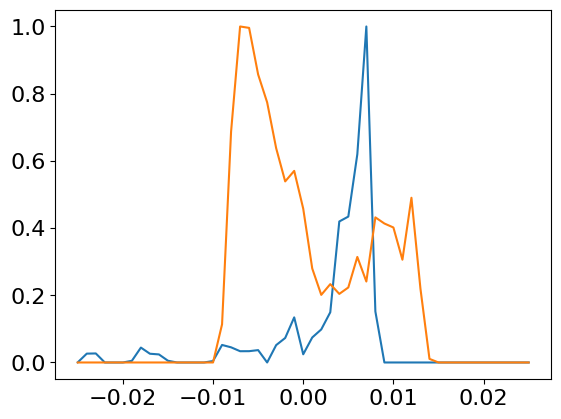

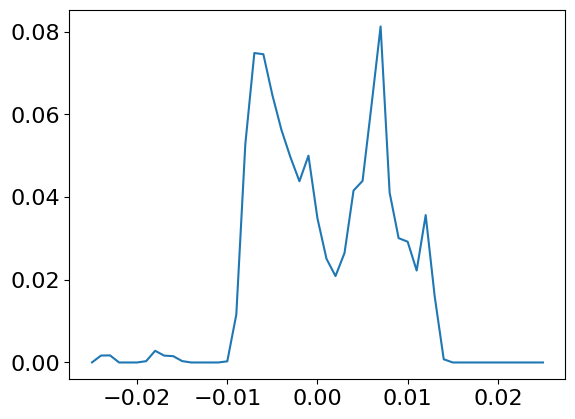

In [6]:
def sigma_plots():
    profs = [get_sigma_profile(n)[0] for n in ['ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']]
    As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]
    for prof in profs:
        plt.plot(prof['sigma [e/A^2]'], prof['p(sigma)*A [A^2]']/prof['p(sigma)*A [A^2]'].max())
    plt.figure()
    x = [0.235000029,1-0.235000029]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])
    plt.plot(profs[0]['sigma [e/A^2]'], psigma_mix);
sigma_plots()

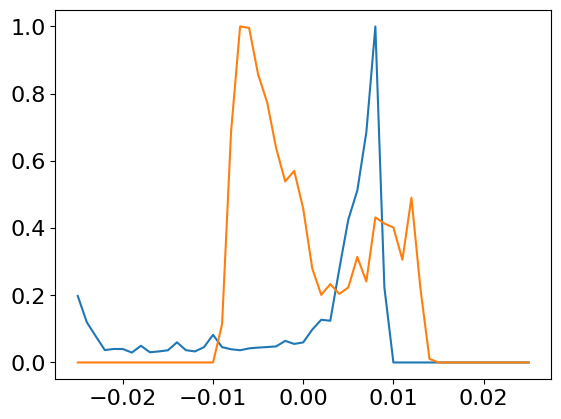

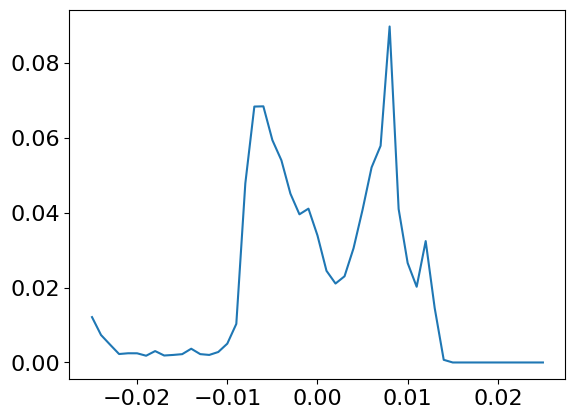

In [7]:
def sigma_plots():
    profs = [get_sigma_profile(n)[0] for n in ['SODIUM TETRACHLOROALUMINATE','PROPYLENE CARBONATE']]
    As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]
    for prof in profs:
        plt.plot(prof['sigma [e/A^2]'], prof['p(sigma)*A [A^2]']/prof['p(sigma)*A [A^2]'].max())
    plt.figure()
    x = [0.235000029,1-0.235000029]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])
    plt.plot(profs[0]['sigma [e/A^2]'], psigma_mix);
sigma_plots()

In [8]:
def get_Gamma(T, psigma):
    """
    Get the value of Γ (capital gamma) for the given sigma profile
    """
    Gamma = np.ones_like(psigma)
    AA = np.exp(-DELTAW/(R*T))*psigma # constant and can be pre-calculated outside of the loop
    for i in range(50):     # originally: for i in range(50):
        Gammanew = 1/np.sum(AA*Gamma, axis=1)
        difference = np.abs((Gamma-Gammanew)/Gamma)
        Gamma = (Gammanew + Gamma)/2
        if np.max(difference) < 1e-8:
            break
        else:
            pass
    return Gamma

def get_lngamma_resid(T, i, psigma_mix, prof, lnGamma_mix = None):
    """
    The residual contribution to ln(γ_i)
    """
    # For the mixture
    if lnGamma_mix is None:
        lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    # For this component
    psigma = np.array(prof['p(sigma)'])
    A_i = prof['A'].iloc[0]
    lnGammai = np.log(get_Gamma(T, psigma))
    lngammai = A_i/AEFFPRIME*np.sum(psigma*(lnGamma_mix - lnGammai))
    return lngammai

def get_lngamma_comb(T, x, i, profs, V_COSMO_A3):
    """ 
    The combinatorial part of ln(γ_i)
    """
    A = np.array([prof['p(sigma)*A [A^2]'].sum() for prof in profs])
    q = A/q0
    r = V_COSMO_A3/r0
    theta_i = x[i]*q[i]/np.dot(x,q)
    phi_i = x[i]*r[i]/np.dot(x,r)
    l = z_coordination/2*(r-q) - (r-1)
    return (np.log(phi_i/x[i])+z_coordination/2*q[i]*np.log(theta_i/phi_i)
           +l[i]-phi_i/x[i]*np.dot(x,l))

def get_lngamma(T, x, i, psigma_mix, profs, V_COSMO_A3, lnGamma_mix = None):
    """ 
    Sum of the contributions to ln(γ_i)
    """
    return (get_lngamma_resid(T, i, psigma_mix, profs[i], lnGamma_mix=lnGamma_mix) 
           + get_lngamma_comb(T, x, i, profs, V_COSMO_A3))

In [9]:
'''
No dispersion contribution for AlCl3-containing system (systems with Al in general).

From A Benchmark Open-Source Implementation of COSMO-SAC:
For the COSMO-SAC-dsp model, if an atom other than C, H, O, N, F, Cl is included, the associated
value of ϵ_Atom,i/kB is set to an undefined value and the calculation is aborted.
'''

profs = [get_sigma_profile(n)[0] for n in ['ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]
x = [0.5,1-0.5]
T = 298
psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])
profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']])
V_COSMO_A3 = np.array(V_COSMO_A3)
i = 0
for i in range(2):
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])
    lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    print(i, get_lngamma_resid(T, i, psigma_mix, profs[i], lnGamma_mix=lnGamma_mix), get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix))
    get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)
    

0 -4.60402039225558 -4.603891727322861
1 -2.9178758432639924 -2.9177572397581732


### Solid-liquid equilibrium

$ \ln(x_i \gamma_i) = \frac{\Delta h_{m,i}}{R} \big( \frac{1}{T_{m,i}} - \frac{1}{T} \big)$

$ \ln x_i = -\ln \gamma_i + \frac{\Delta h_{m,i}}{R} \big( \frac{1}{T_{m,i}} - \frac{1}{T} \big)$

In [10]:
# Melting point and enthalpy of fusion of AlCl3 and PC

Tm_AlCl3 = 192.6+273.15  # K
dH_fus_AlCl3 = 35.35     # kJ/mol
Tm_PC = -48.8+273.15     # K
dH_fus_PC = 8            # kJ/mol (experimental values range from 7-9.6 kJ/mol, https://doi.org/10.1021/acs.jced.7b00578

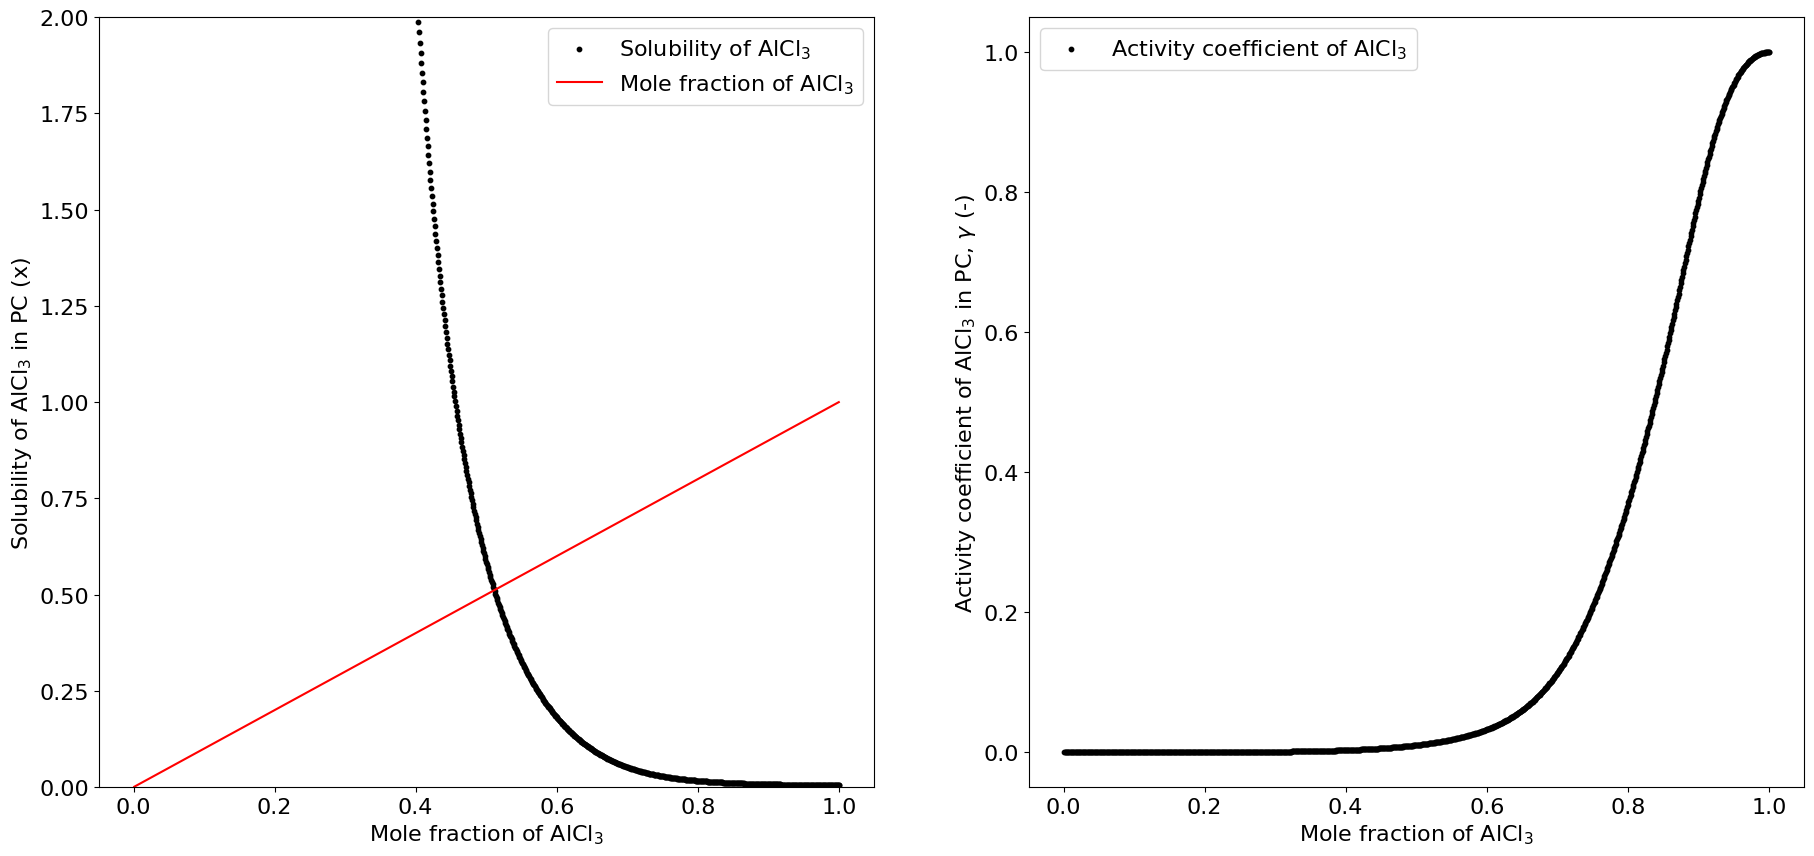

Solubility of AlCl3 (x): 0.51
Solubility of AlCl3 (x) assuming ideal solution (gamma = 1): 0.006


In [25]:
# Calculate solubilities of AlCl3 in PC

# Mole fractions of AlCl3 and PC
x_AlCl3 = np.linspace(0.001,1,1000)
x_PC = 1-x_AlCl3

T = 298

profs = [get_sigma_profile(n)[0] for n in ['ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_AlCl3)):
    x = [x_AlCl3[idx], x_PC[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']])    
    V_COSMO_A3 = np.array(V_COSMO_A3)
    lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    
    for i in range(2):
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_AlCl3*1000/(gas_R*Tm_AlCl3)*(1-Tm_AlCl3/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == 999:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label='Solubility of AlCl$_3$')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label='Activity coefficient of AlCl$_3$')

ax1.plot(x_AlCl3, x_AlCl3, color='red', label='Mole fraction of AlCl$_3$')
ax1.set_xlabel('Mole fraction of AlCl$_3$')
ax1.set_ylabel('Solubility of AlCl$_3$ in PC (x)')
ax1.set_ylim(bottom=0, top=2)
ax1.legend()

ax2.set_xlabel('Mole fraction of AlCl$_3$')
ax2.set_ylabel(r'Activity coefficient of AlCl$_3$ in PC, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

# Find value and index where mole fraction of AlCl3 is equal to solubility of AlCl3 (i.e., all AlCl3 is dissolved)
for x in range(len(x_AlCl3)):
    val = abs(x_sol[x] - x_AlCl3[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(f'Solubility of AlCl3 (x): {x_AlCl3[min_idx]:.2f}')

ln_x_ideal = dH_fus_AlCl3*1000/(gas_R*Tm_AlCl3)*(1-Tm_AlCl3/T)
print(f'Solubility of AlCl3 (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')

In [21]:
# Compute experimental solubility of AlCl3 in PC (3.2 M)

density_PC = 1.2047     # g/cm3
density_AlCl3 = 2.48    # g/cm3
c = 3.2                 # mol/l salt concentration
Mw_PC = 102.089         # g/mol molar weight
Mw_AlCl3 = 133.341      # g/mol molar weight

# assume electrolyte to be composed one litre of PC and 3.2 mole of AlCl3 salt
tot_vol = 1000              # cm3/litre
mol_AlCl3 = c               # mol of AlCl3
mass_AlCl3 = mol_AlCl3*Mw_AlCl3       # g of AlCl3
vol_AlCl3 = mass_AlCl3/density_AlCl3  # cm3 of AlCl3

vol_PC = tot_vol-vol_AlCl3
mass_PC = vol_PC*density_PC  # g of PC
mol_PC = mass_PC/Mw_PC       # mol of PC

sol_x_AlCl3 = mol_AlCl3/(mol_PC+mol_AlCl3)

print(f'Experimental solubility of AlCl3 assuming ideal solution (mole fraction): {sol_x_AlCl3:.3f}')

Experimental solubility of AlCl3 assuming ideal solution (mole fraction): 0.247


In [27]:
abs_dev = abs(x_AlCl3[min_idx]-sol_x_AlCl3)
print(f'Absolute deviation: {abs_dev:.3f}')

Absolute deviation: 0.264


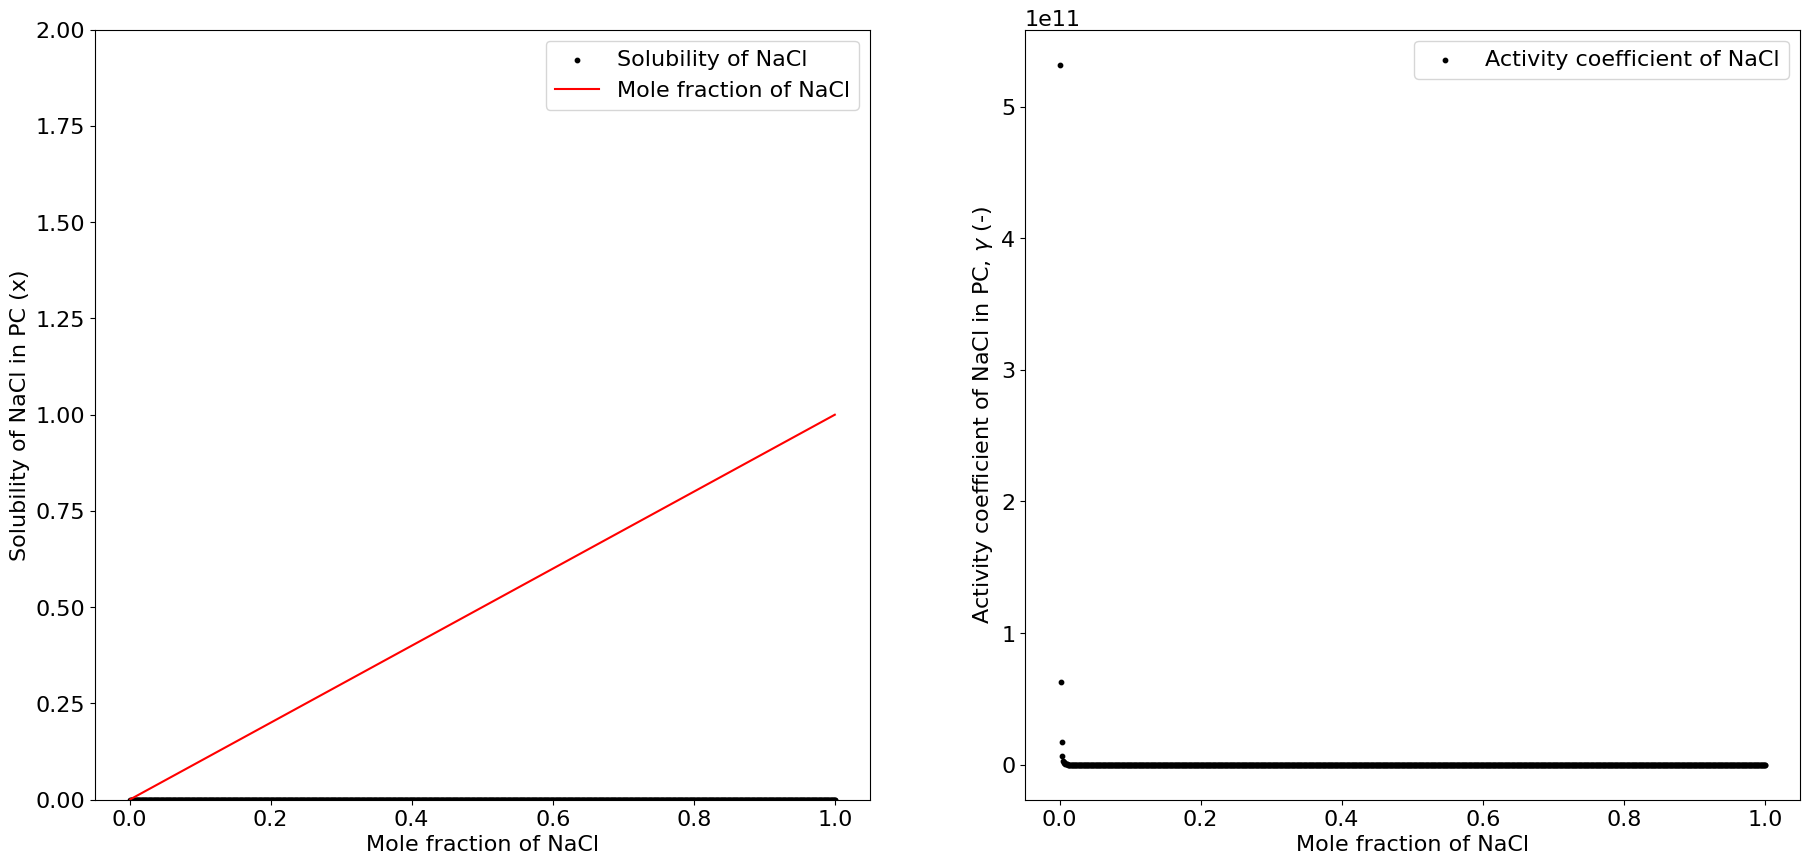

Solubility of NaCl (x): 0.00
Solubility of NaCl (x) assuming ideal solution (gamma = 1): 0.000


In [28]:
# Calculate solubilities of NaCl in PC

# Melting point and enthalpy of fusion of NaCl
Tm_NaCl = 802.018+273.15  # K
dH_fus_NaCl = 28.16       # kJ/mol

# Mole fractions of NaCl and PC
x_NaCl = np.linspace(0.001,1,1000)
x_PC = 1-x_NaCl

T = 298

profs = [get_sigma_profile(n)[0] for n in ['SODIUM CHLORIDE','PROPYLENE CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_NaCl)):
    x = [x_NaCl[idx], x_PC[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['SODIUM CHLORIDE','PROPYLENE CARBONATE']])    
    V_COSMO_A3 = np.array(V_COSMO_A3)
    lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    
    for i in range(2):
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_NaCl*1000/(gas_R*Tm_NaCl)*(1-Tm_NaCl/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == 999:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label='Solubility of NaCl')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label='Activity coefficient of NaCl')

ax1.plot(x_NaCl, x_NaCl, color='red', label='Mole fraction of NaCl')
ax1.set_xlabel('Mole fraction of NaCl')
ax1.set_ylabel('Solubility of NaCl in PC (x)')
ax1.set_ylim(bottom=0, top=2)
ax1.legend()

ax2.set_xlabel('Mole fraction of NaCl')
ax2.set_ylabel(r'Activity coefficient of NaCl in PC, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

# Find value and index where mole fraction of NaCl is equal to solubility of NaCl (i.e., all NaCl is dissolved)
for x in range(len(x_NaCl)):
    val = abs(x_sol[x] - x_NaCl[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(f'Solubility of NaCl (x): {x_NaCl[min_idx]:.2f}')

ln_x_ideal = dH_fus_NaCl*1000/(gas_R*Tm_NaCl)*(1-Tm_NaCl/T)
print(f'Solubility of NaCl (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')

In [11]:
# 1 molal mixture of AlCl3 and PC 

mass_PC = 5.9751      # g, weighed out
mass_AlCl3 = 0.8001   # g, weighed out

mol_PC = mass_PC/Mw_PC
mol_AlCl3 = mass_AlCl3/Mw_AlCl3

x0_AlCl3 = mol_AlCl3/(mol_AlCl3 + mol_PC)
x0_PC = mol_PC/(mol_AlCl3 + mol_PC)
print(mol_AlCl3)
print(x0_AlCl3)
print(x0_PC)

# Melting point and enthalpy of fusion of NaCl
Tm_NaCl = 802.018+273.15  # K
dH_fus_NaCl = 28.16       # kJ/mol

0.006000404976713839
0.09298808938065897
0.9070119106193409


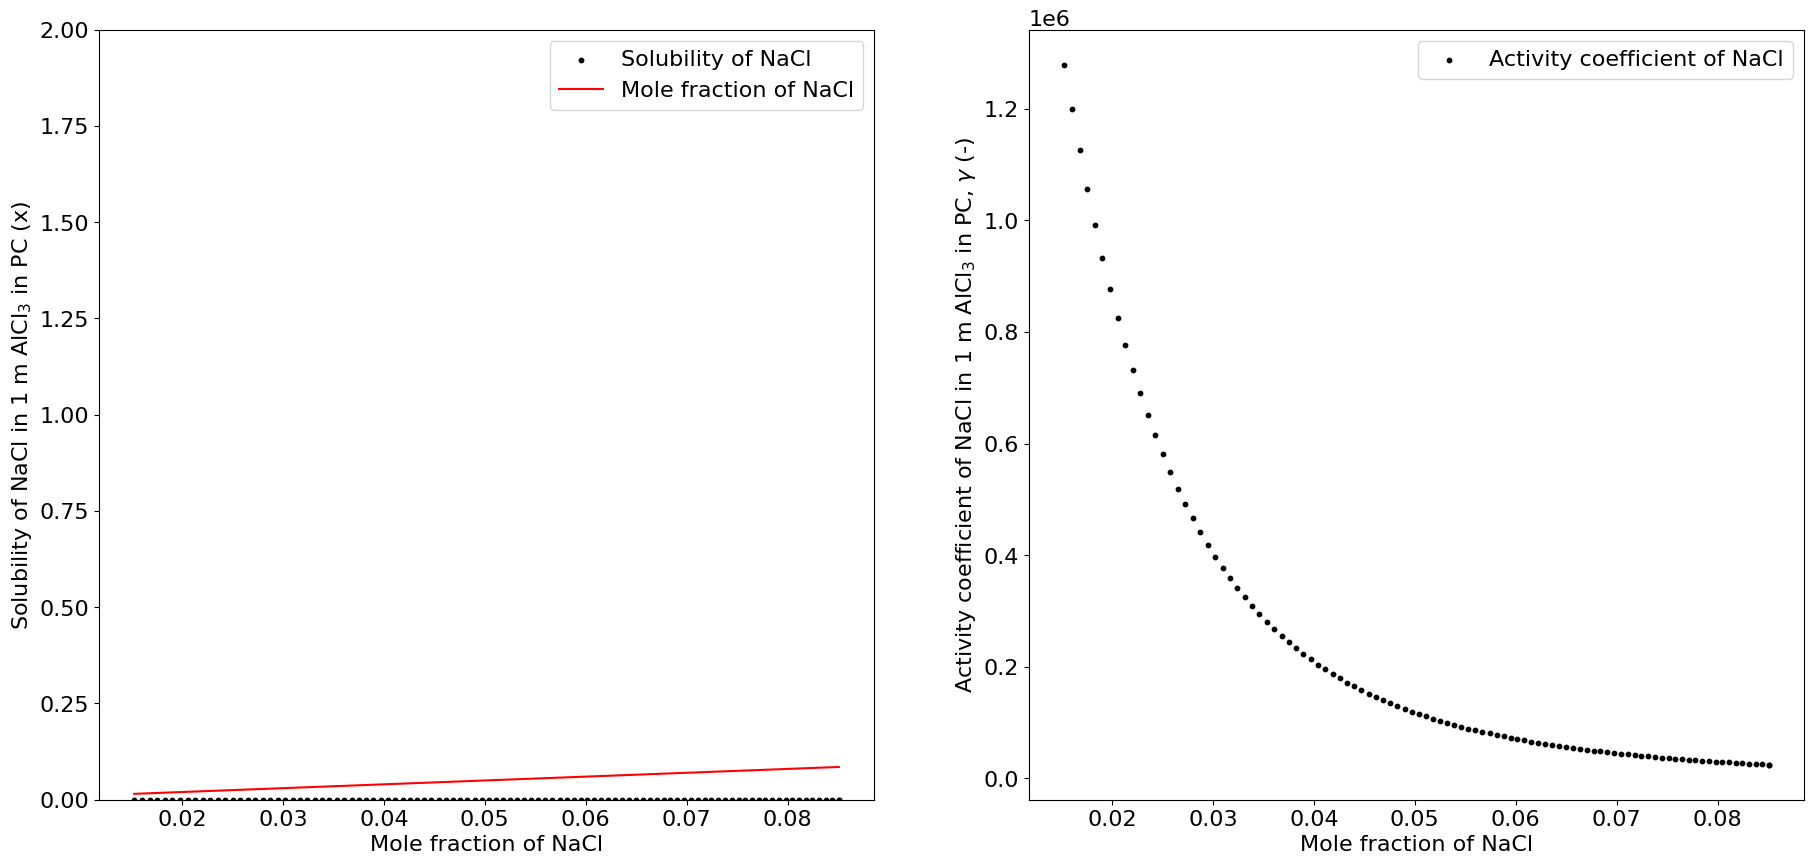

[np.float64(2.114864452951878e-10), np.float64(2.2549092438602286e-10), np.float64(2.403176599006067e-10), np.float64(2.5599483961076465e-10), np.float64(2.7255041001249066e-10), np.float64(2.900122592237513e-10), np.float64(3.084083514841035e-10), np.float64(3.2776682555966566e-10), np.float64(3.4811606628054934e-10), np.float64(3.6948475610118645e-10), np.float64(3.9190191181693157e-10), np.float64(4.153969102569869e-10), np.float64(4.399995057959495e-10), np.float64(4.657398417995823e-10), np.float64(4.926484575806338e-10), np.float64(5.20756292039597e-10), np.float64(5.500946848671704e-10), np.float64(5.806953759630754e-10), np.float64(6.125905035603972e-10), np.float64(6.458126014208597e-10), np.float64(6.803945953739465e-10), np.float64(7.163697994032535e-10), np.float64(7.537719114315524e-10), np.float64(7.926350089166574e-10), np.float64(8.329935443409648e-10), np.float64(8.748823406551451e-10), np.float64(9.183365867199545e-10), np.float64(9.633918327773685e-10), np.float64(1.

In [41]:
# Calculate solubilities of NaCl in 1 molal AlCl3 + PC mixture
# 1 molal of NaCl in PC

mol_final_NaCl = mol_AlCl3
x_final_NaCl = mol_final_NaCl/(mol_final_NaCl + mol_AlCl3 + mol_PC)

# Mole fractions of NaCl, AlCl3 and PC
mol_NaCl = np.linspace(0.001,mol_final_NaCl,100)

x_NaCl = mol_NaCl/(mol_AlCl3 + mol_PC + mol_NaCl)
x_AlCl3 = mol_AlCl3/(mol_AlCl3 + mol_PC + mol_NaCl)
x_PC = mol_PC/(mol_AlCl3 + mol_PC + mol_NaCl)

T = 298

profs = [get_sigma_profile(n)[0] for n in ['SODIUM CHLORIDE','ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_NaCl)):
    x = [x_NaCl[idx],x_AlCl3[idx], x_PC[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(3)])/sum([x[i]*As[i] for i in range(3)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['SODIUM CHLORIDE','ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']])
    V_COSMO_A3 = np.array(V_COSMO_A3)
    lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    
    for i in range(3):
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_NaCl*1000/(gas_R*Tm_NaCl)*(1-Tm_NaCl/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == 99:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label='Solubility of NaCl')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label='Activity coefficient of NaCl')

ax1.plot(x_NaCl, x_NaCl, color='red', label='Mole fraction of NaCl')
ax1.set_xlabel('Mole fraction of NaCl')
ax1.set_ylabel('Solubility of NaCl in 1 m AlCl$_3$ in PC (x)')
ax1.set_ylim(bottom=0, top=2)
ax1.legend()

ax2.set_xlabel('Mole fraction of NaCl')
ax2.set_ylabel(r'Activity coefficient of NaCl in 1 m AlCl$_3$ in PC, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

#print(x_sol)

# Find value and index where mole fraction of NaCl is equal to solubility of NaCl (i.e., all NaCl is dissolved)
for x in range(len(x_NaCl)):
    val = abs(x_sol[x] - x_NaCl[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(f'Solubility of NaCl (x): {x_NaCl[min_idx]:.3f}')

ln_x_ideal = dH_fus_NaCl*1000/(gas_R*Tm_NaCl)*(1-Tm_NaCl/T)
print(f'Solubility of NaCl (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')

In [18]:
# Melting point and enthalpy of fusion of NaAlCl4

Tm_NaAlCl4 = 156.7+273.15  # K
dH_fus_NaAlCl4 = 15.5      # kJ/mol    both from https://pubs.acs.org/doi/pdf/10.1021/ic00173a015

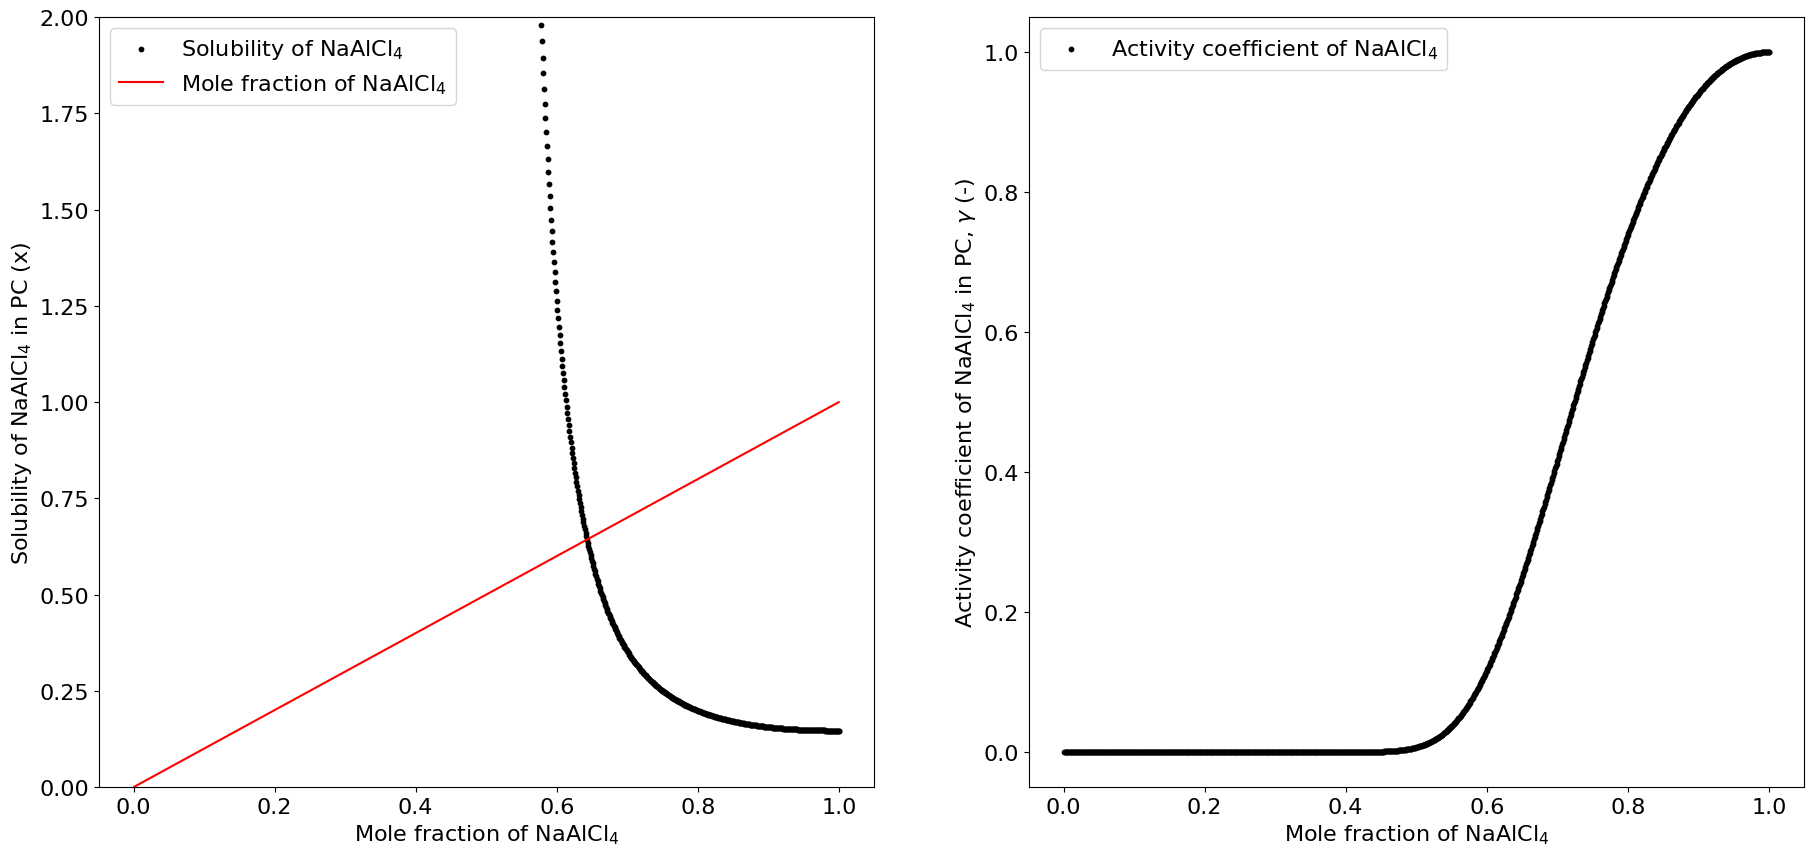

Solubility of NaAlCl4 (x): 0.64
Solubility of NaAlCl4 (x) assuming ideal solution (gamma = 1): 0.147


In [32]:
# Calculate solubilities of NaAlCl4 in PC

# Mole fractions of NaAlCl4 and PC
x_NaAlCl4 = np.linspace(0.001,1,1000)
x_PC = 1-x_NaAlCl4

T = 298

profs = [get_sigma_profile(n)[0] for n in ['SODIUM TETRACHLOROALUMINATE','PROPYLENE CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_NaAlCl4)):
    x = [x_NaAlCl4[idx], x_PC[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['SODIUM TETRACHLOROALUMINATE','PROPYLENE CARBONATE']])
    V_COSMO_A3 = np.array(V_COSMO_A3)
    i = 0
    for i in range(2):
        psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])
        lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
        
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_NaAlCl4*1000/(gas_R*Tm_NaAlCl4)*(1-Tm_NaAlCl4/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == 999:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label='Solubility of NaAlCl$_4$')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label='Activity coefficient of NaAlCl$_4$')

ax1.plot(x_NaAlCl4, x_NaAlCl4, color='red', label='Mole fraction of NaAlCl$_4$')
ax1.set_xlabel('Mole fraction of NaAlCl$_4$')
ax1.set_ylabel('Solubility of NaAlCl$_4$ in PC (x)')
ax1.set_ylim(bottom=0, top=2)
ax1.legend()

ax2.set_xlabel('Mole fraction of NaAlCl$_4$')
ax2.set_ylabel(r'Activity coefficient of NaAlCl$_4$ in PC, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

# Find value and index where mole fraction of NaAlCl4 is equal to solubility of NaAlCl4 (i.e., all NaAlCl4 is dissolved)
for x in range(len(x_NaAlCl4)):
    val = abs(x_sol[x] - x_NaAlCl4[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(f'Solubility of NaAlCl4 (x): {x_NaAlCl4[min_idx]:.2f}')

ln_x_ideal = dH_fus_NaAlCl4*1000/(gas_R*Tm_NaAlCl4)*(1-Tm_NaAlCl4/T)
print(f'Solubility of NaAlCl4 (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')

In [42]:
# 1 molal mixture of AlCl3 and PC

mass_PC = 5.9751      # g, weighed out
mass_AlCl3 = 0.8001   # g, weighed out

mol_PC = mass_PC/Mw_PC
mol_AlCl3 = mass_AlCl3/Mw_AlCl3

x0_AlCl3 = mol_AlCl3/(mol_AlCl3 + mol_PC)
x0_PC = mol_PC/(mol_AlCl3 + mol_PC)
print(mol_AlCl3)
print(x0_AlCl3)
print(x0_PC)

# Melting point and enthalpy of fusion of KCl
Tm_KCl = 771+273.15    # K
dH_fus_KCl = 26.28     # kJ/mol

0.006000404976713839
0.09298808938065897
0.9070119106193409


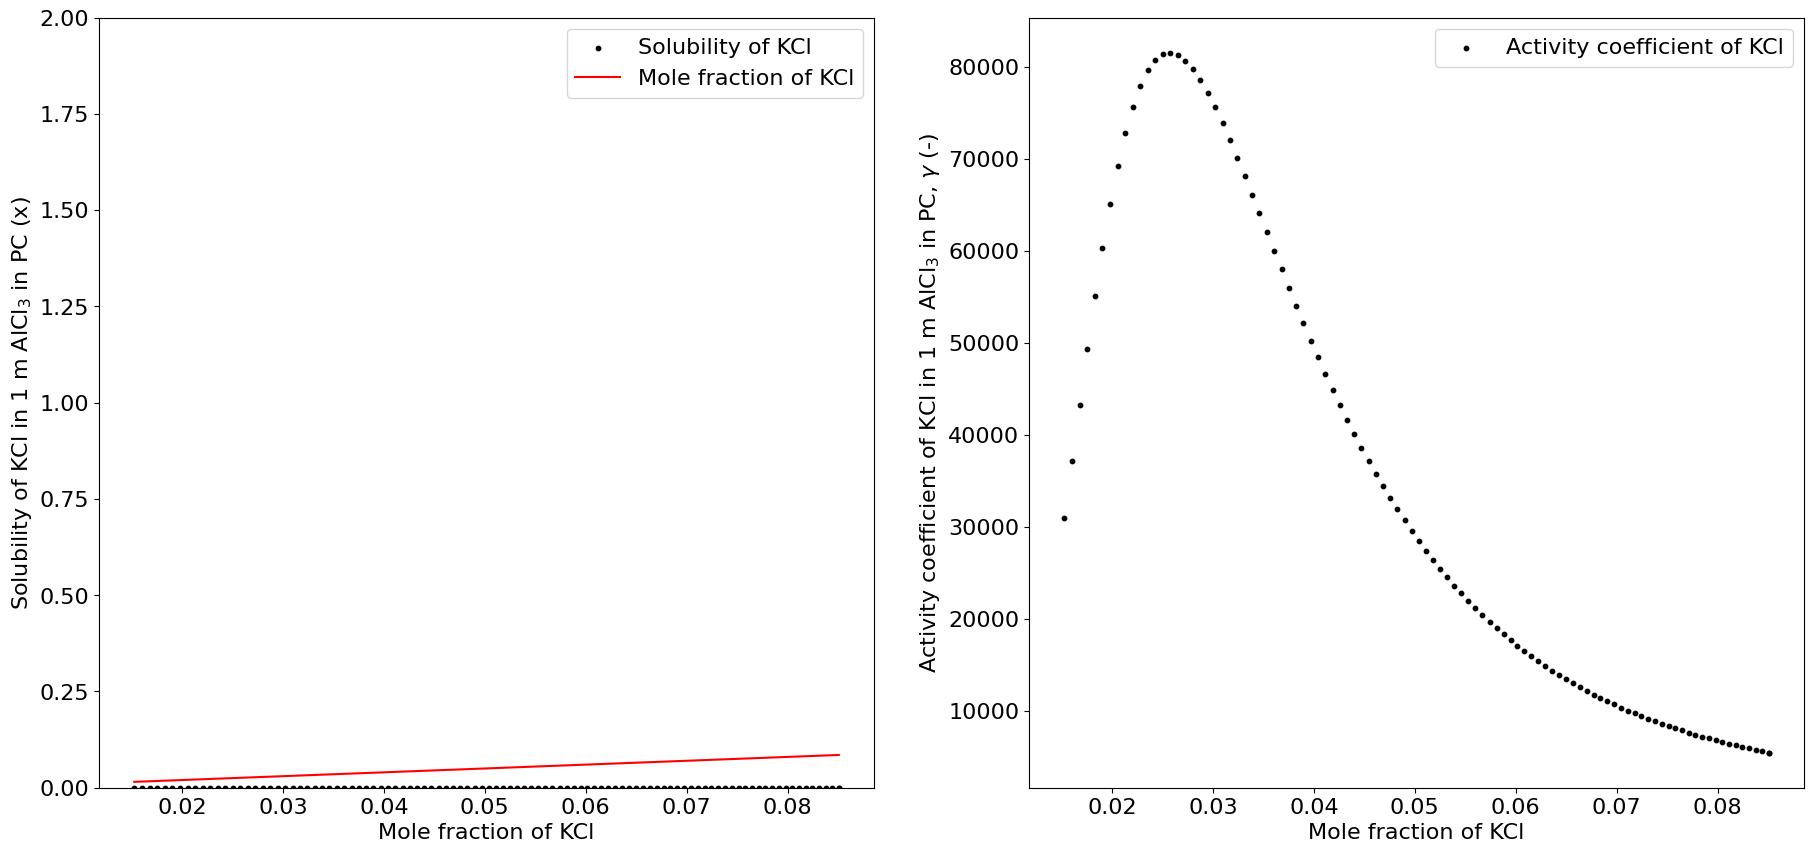

[np.float64(1.6499314005230692e-08), np.float64(1.3767932036257375e-08), np.float64(1.1802990063734319e-08), np.float64(1.0359781879556463e-08), np.float64(9.282444403090086e-09), np.float64(8.468681006841754e-09), np.float64(7.84954437985573e-09), np.float64(7.3774536242912765e-09), np.float64(7.018874498178292e-09), np.float64(6.749725049547479e-09), np.float64(6.552420106747928e-09), np.float64(6.4139270347286315e-09), np.float64(6.324460350262803e-09), np.float64(6.276588709028355e-09), np.float64(6.2646133823539506e-09), np.float64(6.284128755677691e-09), np.float64(6.331706935041269e-09), np.float64(6.4046683042441705e-09), np.float64(6.500912475794109e-09), np.float64(6.618792254704998e-09), np.float64(6.757018624826353e-09), np.float64(6.914588375153771e-09), np.float64(7.090728432163554e-09), np.float64(7.284852648037496e-09), np.float64(7.49652796693487e-09), np.float64(7.725447717159534e-09), np.float64(7.971410365044198e-09), np.float64(8.234302489417503e-09), np.float64(8.

In [43]:
# Calculate solubilities of KCl in 1 molal AlCl3 + PC mixture
# 1 molal of KCl in PC

mol_final_KCl = mol_AlCl3
x_final_KCl = mol_final_KCl/(mol_final_KCl + mol_AlCl3 + mol_PC)

# Mole fractions of KCl, AlCl3 and PC
mol_KCl = np.linspace(0.001,mol_final_KCl,100)

x_KCl = mol_KCl/(mol_AlCl3 + mol_PC + mol_KCl)
x_AlCl3 = mol_AlCl3/(mol_AlCl3 + mol_PC + mol_KCl)
x_PC = mol_PC/(mol_AlCl3 + mol_PC + mol_KCl)

T = 298

profs = [get_sigma_profile(n)[0] for n in ['POTASSIUM CHLORIDE','ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_KCl)):
    x = [x_KCl[idx],x_AlCl3[idx], x_PC[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(3)])/sum([x[i]*As[i] for i in range(3)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['POTASSIUM CHLORIDE','ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']])
    V_COSMO_A3 = np.array(V_COSMO_A3)
    lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    
    for i in range(3):
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_KCl*1000/(gas_R*Tm_KCl)*(1-Tm_KCl/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == 99:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label='Solubility of KCl')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label='Activity coefficient of KCl')

ax1.plot(x_KCl, x_KCl, color='red', label='Mole fraction of KCl')
ax1.set_xlabel('Mole fraction of KCl')
ax1.set_ylabel('Solubility of KCl in 1 m AlCl$_3$ in PC (x)')
ax1.set_ylim(bottom=0, top=2)
ax1.legend()

ax2.set_xlabel('Mole fraction of KCl')
ax2.set_ylabel(r'Activity coefficient of KCl in 1 m AlCl$_3$ in PC, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

#print(x_sol)

# Find value and index where mole fraction of KCl is equal to solubility of KCl (i.e., all KCl is dissolved)
for x in range(len(x_KCl)):
    val = abs(x_sol[x] - x_KCl[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(f'Solubility of KCl (x): {x_KCl[min_idx]:.3f}')

ln_x_ideal = dH_fus_KCl*1000/(gas_R*Tm_KCl)*(1-Tm_KCl/T)
print(f'Solubility of KCl (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')

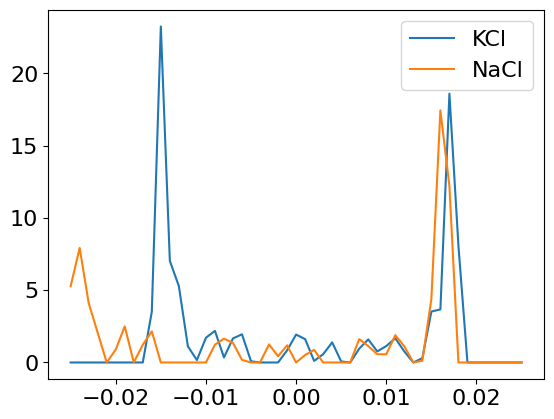

In [39]:
sigma_KCl = get_sigma_profile('POTASSIUM CHLORIDE')
sigma_NaCl = get_sigma_profile('SODIUM CHLORIDE')

plt.plot(sigma_KCl[0]['sigma [e/A^2]'], sigma_KCl[0]['p(sigma)*A [A^2]'], label='KCl')
plt.plot(sigma_NaCl[0]['sigma [e/A^2]'], sigma_NaCl[0]['p(sigma)*A [A^2]'], label='NaCl')
plt.legend()
plt.show()

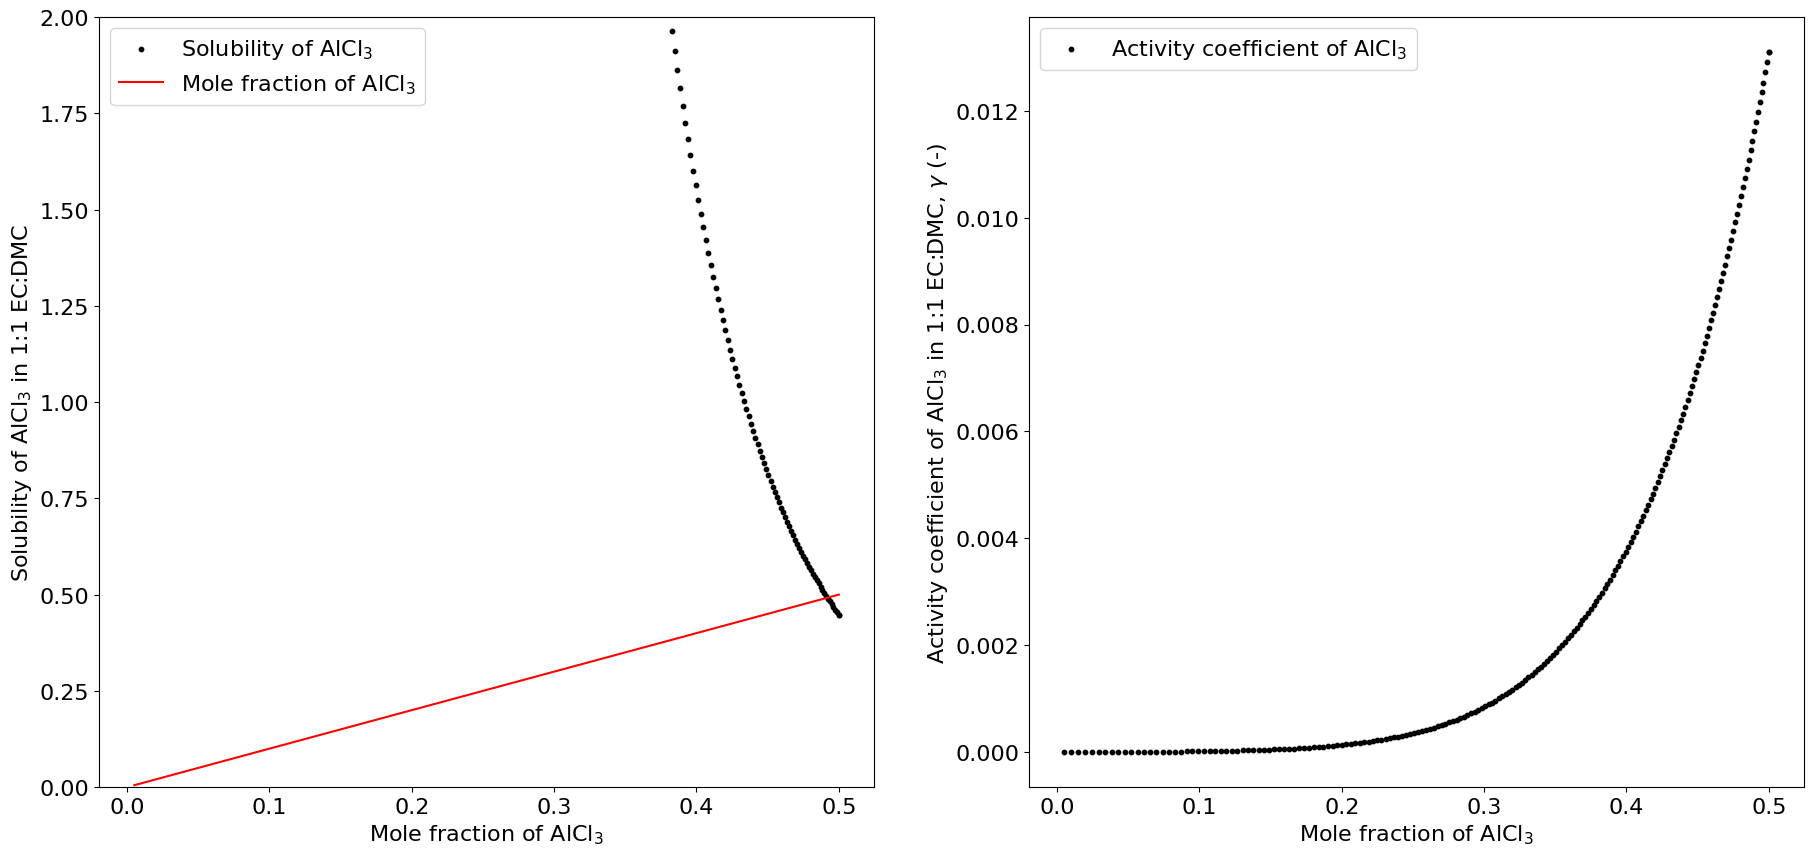

Solubility of AlCl3 (x): 0.492
Solubility of AlCl3 (x) assuming ideal solution (gamma = 1): 0.006


In [17]:
# Calculate solubilities of AlCl3 in 1:1 molar mix of EC:DMC

mol_EC = 1
mol_DMC = 1

# Mole fractions of AlCl3, EC and DMC
mol_AlCl3 = np.linspace(0.01,2,200)

x_AlCl3 = mol_AlCl3/(mol_AlCl3 + mol_DMC + mol_EC)
x_EC = mol_EC/(mol_AlCl3 + mol_DMC + mol_EC)
x_DMC = mol_DMC/(mol_AlCl3 + mol_DMC + mol_EC)

T = 298

profs = [get_sigma_profile(n)[0] for n in ['ALUMINIUM CHLORIDE','ETHYLENE CARBONATE','DIMETHYL CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_AlCl3)):
    x = [x_AlCl3[idx],x_EC[idx],x_DMC[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(3)])/sum([x[i]*As[i] for i in range(3)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['ALUMINIUM CHLORIDE','ETHYLENE CARBONATE','DIMETHYL CARBONATE']])
    V_COSMO_A3 = np.array(V_COSMO_A3)
    lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    
    for i in range(3):
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_AlCl3*1000/(gas_R*Tm_AlCl3)*(1-Tm_AlCl3/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == len(x_AlCl3)-1:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label='Solubility of AlCl$_3$')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label='Activity coefficient of AlCl$_3$')

ax1.plot(x_AlCl3, x_AlCl3, color='red', label='Mole fraction of AlCl$_3$')
ax1.set_xlabel('Mole fraction of AlCl$_3$')
ax1.set_ylabel('Solubility of AlCl$_3$ in 1:1 EC:DMC')
ax1.set_ylim(bottom=0, top=2)
ax1.legend()

ax2.set_xlabel('Mole fraction of AlCl$_3$')
ax2.set_ylabel(r'Activity coefficient of AlCl$_3$ in 1:1 EC:DMC, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

#print(x_sol)

# Find value and index where mole fraction of AlCl3 is equal to solubility of AlCl3 (i.e., all AlCl3 is dissolved)
for x in range(len(x_AlCl3)):
    val = abs(x_sol[x] - x_AlCl3[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(f'Solubility of AlCl3 (x): {x_AlCl3[min_idx]:.3f}')

ln_x_ideal = dH_fus_AlCl3*1000/(gas_R*Tm_AlCl3)*(1-Tm_AlCl3/T)
print(f'Solubility of AlCl3 (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')

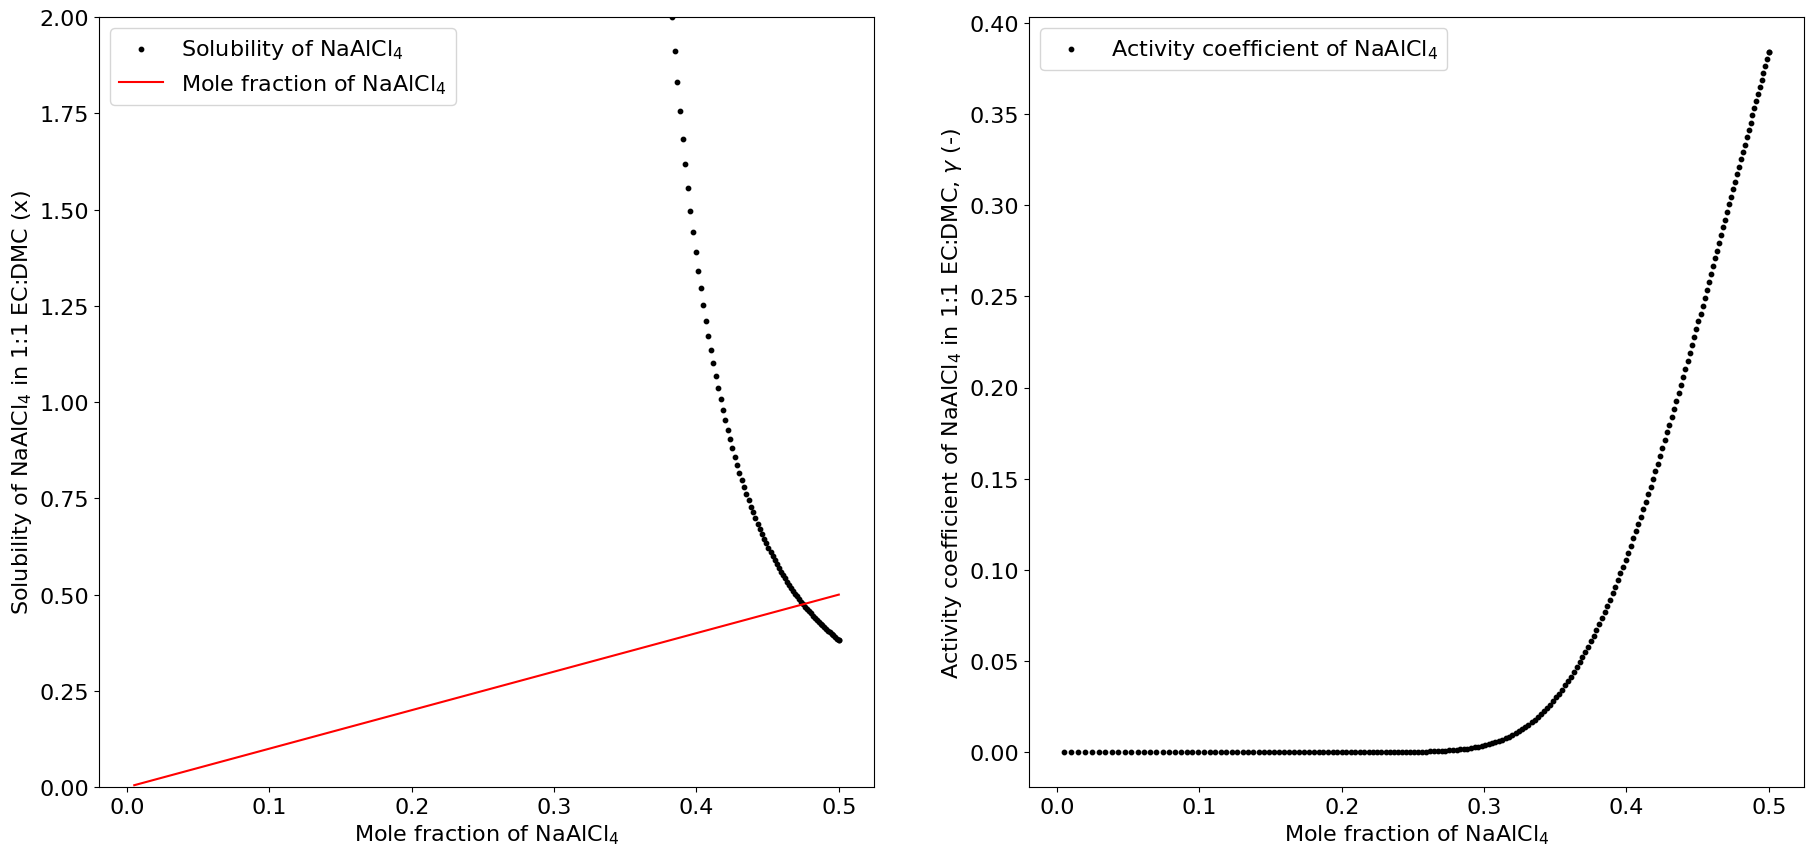

Solubility of NaAlCl4 (x): 0.48
Solubility of NaAlCl4 (x) assuming ideal solution (gamma = 1): 0.147


In [19]:
# Calculate solubilities of NaAlCl4 in 1:1 molar mix of EC:DMC

mol_EC = 1
mol_DMC = 1

# Mole fractions of NaAlCl4, EC and DMC
mol_NaAlCl4 = np.linspace(0.01,2,200)

x_NaAlCl4 = mol_NaAlCl4/(mol_NaAlCl4 + mol_DMC + mol_EC)
x_EC = mol_EC/(mol_NaAlCl4 + mol_DMC + mol_EC)
x_DMC = mol_DMC/(mol_NaAlCl4 + mol_DMC + mol_EC)

T = 298

profs = [get_sigma_profile(n)[0] for n in ['SODIUM TETRACHLOROALUMINATE','ETHYLENE CARBONATE','DIMETHYL CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_NaAlCl4)):
    x = [x_NaAlCl4[idx], x_EC[idx], x_DMC[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['SODIUM TETRACHLOROALUMINATE','ETHYLENE CARBONATE','DIMETHYL CARBONATE']])
    V_COSMO_A3 = np.array(V_COSMO_A3)
    i = 0
    for i in range(3):
        psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])
        lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
        
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_NaAlCl4*1000/(gas_R*Tm_NaAlCl4)*(1-Tm_NaAlCl4/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == len(x_NaAlCl4)-1:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label='Solubility of NaAlCl$_4$')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label='Activity coefficient of NaAlCl$_4$')

ax1.plot(x_NaAlCl4, x_NaAlCl4, color='red', label='Mole fraction of NaAlCl$_4$')
ax1.set_xlabel('Mole fraction of NaAlCl$_4$')
ax1.set_ylabel('Solubility of NaAlCl$_4$ in 1:1 EC:DMC (x)')
ax1.set_ylim(bottom=0, top=2)
ax1.legend()

ax2.set_xlabel('Mole fraction of NaAlCl$_4$')
ax2.set_ylabel(r'Activity coefficient of NaAlCl$_4$ in 1:1 EC:DMC, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

# Find value and index where mole fraction of NaAlCl4 is equal to solubility of NaAlCl4 (i.e., all NaAlCl4 is dissolved)
for x in range(len(x_NaAlCl4)):
    val = abs(x_sol[x] - x_NaAlCl4[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(f'Solubility of NaAlCl4 (x): {x_NaAlCl4[min_idx]:.2f}')

ln_x_ideal = dH_fus_NaAlCl4*1000/(gas_R*Tm_NaAlCl4)*(1-Tm_NaAlCl4/T)
print(f'Solubility of NaAlCl4 (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')

In [23]:
# 1 molal mixture of AlCl3 and PC 

mass_PC = 5.9751      # g, weighed out
mass_AlCl3 = 0.8001   # g, weighed out

mol_PC = mass_PC/Mw_PC
mol_AlCl3 = mass_AlCl3/Mw_AlCl3

x0_AlCl3 = mol_AlCl3/(mol_AlCl3 + mol_PC)
x0_PC = mol_PC/(mol_AlCl3 + mol_PC)
print(mol_AlCl3)
print(x0_AlCl3)
print(x0_PC)

# Melting point and enthalpy of fusion of ZnCl2 salt
Tm_salt = 325+273.15    # K
dH_fus_salt = 10.30     # kJ/mol

0.006000404976713839
0.09298808938065897
0.9070119106193409


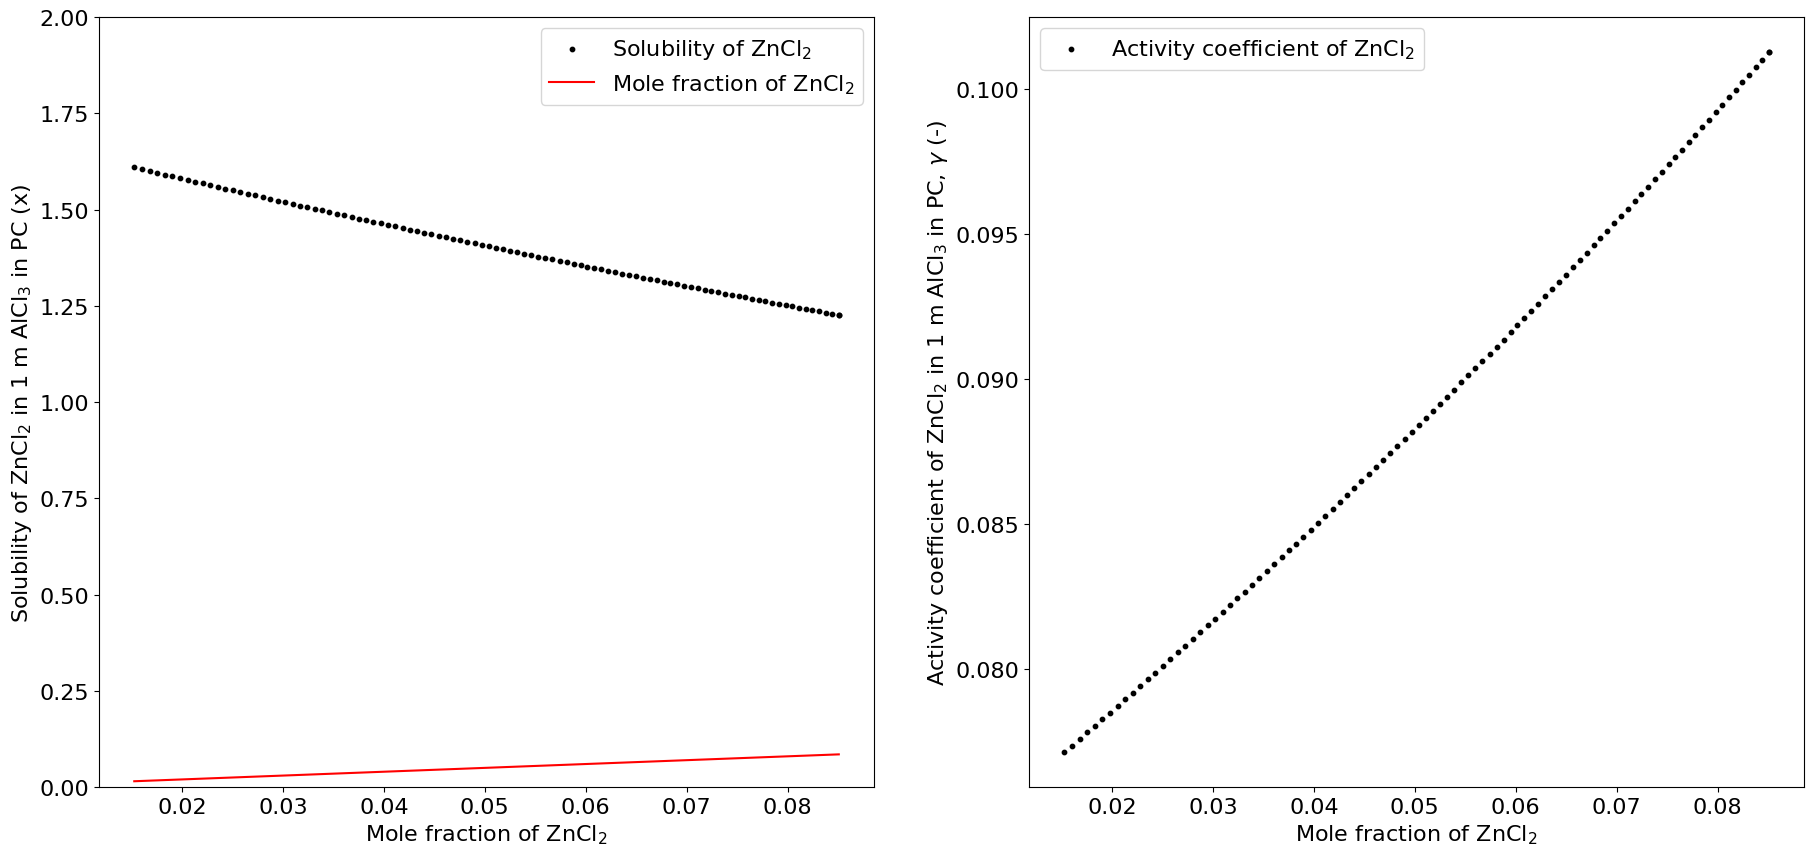

Solubility of ZnCl$_2$ (x): 0.085
Solubility of ZnCl$_2$ (x) assuming ideal solution (gamma = 1): 0.124


In [14]:
# Calculate solubilities of ZnCl2 salt in 1 molal AlCl3 + PC mixture
# up to 1 molal of ZnCl2 in PC

salt = r'ZnCl$_2$'

mol_final_salt = mol_AlCl3

# Mole fractions of salt, AlCl3 and PC
mol_salt = np.linspace(0.001,mol_final_salt,100)

x_salt = mol_salt/(mol_AlCl3 + mol_PC + mol_salt)
x_AlCl3 = mol_AlCl3/(mol_AlCl3 + mol_PC + mol_salt)
x_PC = mol_PC/(mol_AlCl3 + mol_PC + mol_salt)

T = 298

profs = [get_sigma_profile(n)[0] for n in ['ZINC CHLORIDE','ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_salt)):
    x = [x_salt[idx],x_AlCl3[idx], x_PC[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(3)])/sum([x[i]*As[i] for i in range(3)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['ZINC CHLORIDE','ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']])
    V_COSMO_A3 = np.array(V_COSMO_A3)
    lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    
    for i in range(3):
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_salt*1000/(gas_R*Tm_salt)*(1-Tm_salt/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == 99:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label=f'Solubility of {salt}')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label=f'Activity coefficient of {salt}')

ax1.plot(x_salt, x_salt, color='red', label=f'Mole fraction of {salt}')
ax1.set_xlabel(f'Mole fraction of {salt}')
ax1.set_ylabel(f'Solubility of {salt} in 1 m AlCl$_3$ in PC (x)')
ax1.set_ylim(bottom=0, top=2)
ax1.legend()

ax2.set_xlabel(f'Mole fraction of {salt}')
ax2.set_ylabel(rf'Activity coefficient of {salt} in 1 m AlCl$_3$ in PC, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

#print(x_sol)

# Find value and index where mole fraction of salt is equal to solubility of salt (i.e., all salt is dissolved)
for x in range(len(x_salt)):
    val = abs(x_sol[x] - x_salt[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(f'Solubility of {salt} (x): {x_salt[min_idx]:.3f}')

ln_x_ideal = dH_fus_salt*1000/(gas_R*Tm_salt)*(1-Tm_salt/T)
print(f'Solubility of {salt} (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')

In [22]:
# 1 molal mixture of AlCl3 and PC 

mass_PC = 5.9751      # g, weighed out
mass_AlCl3 = 0.8001   # g, weighed out

mol_PC = mass_PC/Mw_PC
mol_AlCl3 = mass_AlCl3/Mw_AlCl3

x0_AlCl3 = mol_AlCl3/(mol_AlCl3 + mol_PC)
x0_PC = mol_PC/(mol_AlCl3 + mol_PC)
print(mol_AlCl3)
print(x0_AlCl3)
print(x0_PC)

# Melting point and enthalpy of fusion of FeCl3 salt
Tm_salt = 307.6+273.15   # K
dH_fus_salt = 40         # kJ/mol

0.006000404976713839
0.09298808938065897
0.9070119106193409


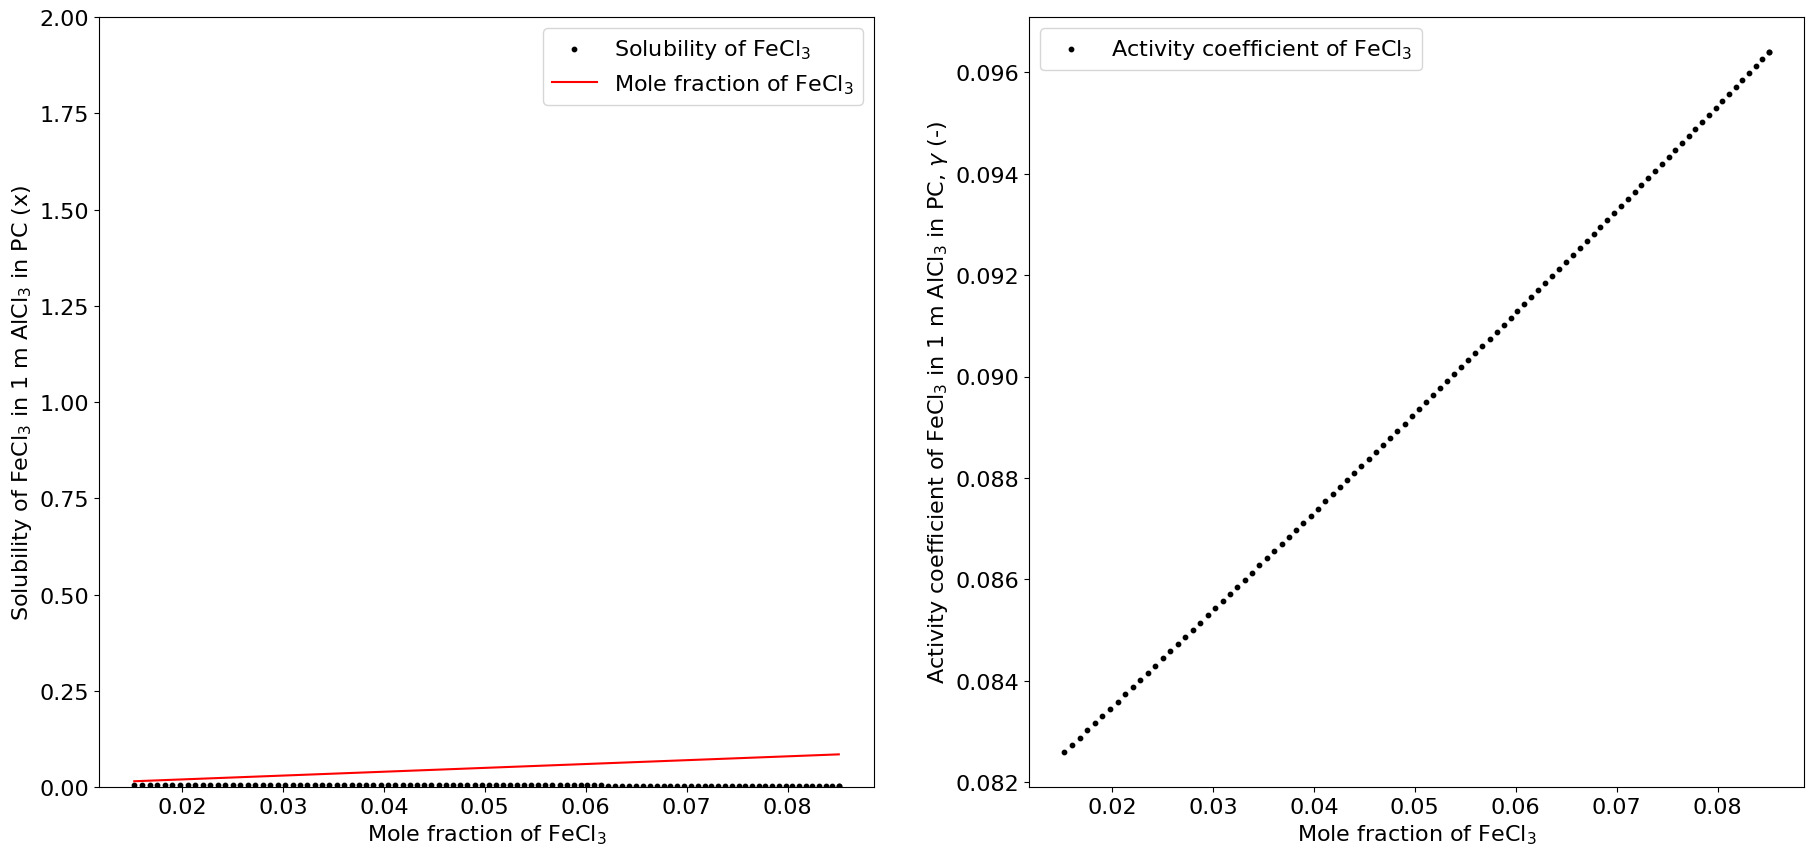

Solubility of FeCl$_3$ (x): 0.015
Solubility of FeCl$_3$ (x) assuming ideal solution (gamma = 1): 0.000


In [17]:
# Calculate solubilities of FeCl3 salt in 1 molal AlCl3 + PC mixture
# up to 1 molal of FeCl3 in AlCl3:PC

salt = r'FeCl$_3$'

mol_final_salt = mol_AlCl3

# Mole fractions of salt, AlCl3 and PC
mol_salt = np.linspace(0.001,mol_final_salt,100)

x_salt = mol_salt/(mol_AlCl3 + mol_PC + mol_salt)
x_AlCl3 = mol_AlCl3/(mol_AlCl3 + mol_PC + mol_salt)
x_PC = mol_PC/(mol_AlCl3 + mol_PC + mol_salt)

T = 298

profs = [get_sigma_profile(n)[0] for n in ['IRON CHLORIDE','ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_salt)):
    x = [x_salt[idx],x_AlCl3[idx], x_PC[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(3)])/sum([x[i]*As[i] for i in range(3)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['IRON CHLORIDE','ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']])
    V_COSMO_A3 = np.array(V_COSMO_A3)
    lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    
    for i in range(3):
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_salt*1000/(gas_R*Tm_salt)*(1-Tm_salt/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == 99:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label=f'Solubility of {salt}')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label=f'Activity coefficient of {salt}')

ax1.plot(x_salt, x_salt, color='red', label=f'Mole fraction of {salt}')
ax1.set_xlabel(f'Mole fraction of {salt}')
ax1.set_ylabel(f'Solubility of {salt} in 1 m AlCl$_3$ in PC (x)')
ax1.set_ylim(bottom=0, top=2)
ax1.legend()

ax2.set_xlabel(f'Mole fraction of {salt}')
ax2.set_ylabel(rf'Activity coefficient of {salt} in 1 m AlCl$_3$ in PC, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

#print(x_sol)

# Find value and index where mole fraction of salt is equal to solubility of salt (i.e., all salt is dissolved)
for x in range(len(x_salt)):
    val = abs(x_sol[x] - x_salt[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(f'Solubility of {salt} (x): {x_salt[min_idx]:.3f}')

ln_x_ideal = dH_fus_salt*1000/(gas_R*Tm_salt)*(1-Tm_salt/T)
print(f'Solubility of {salt} (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')

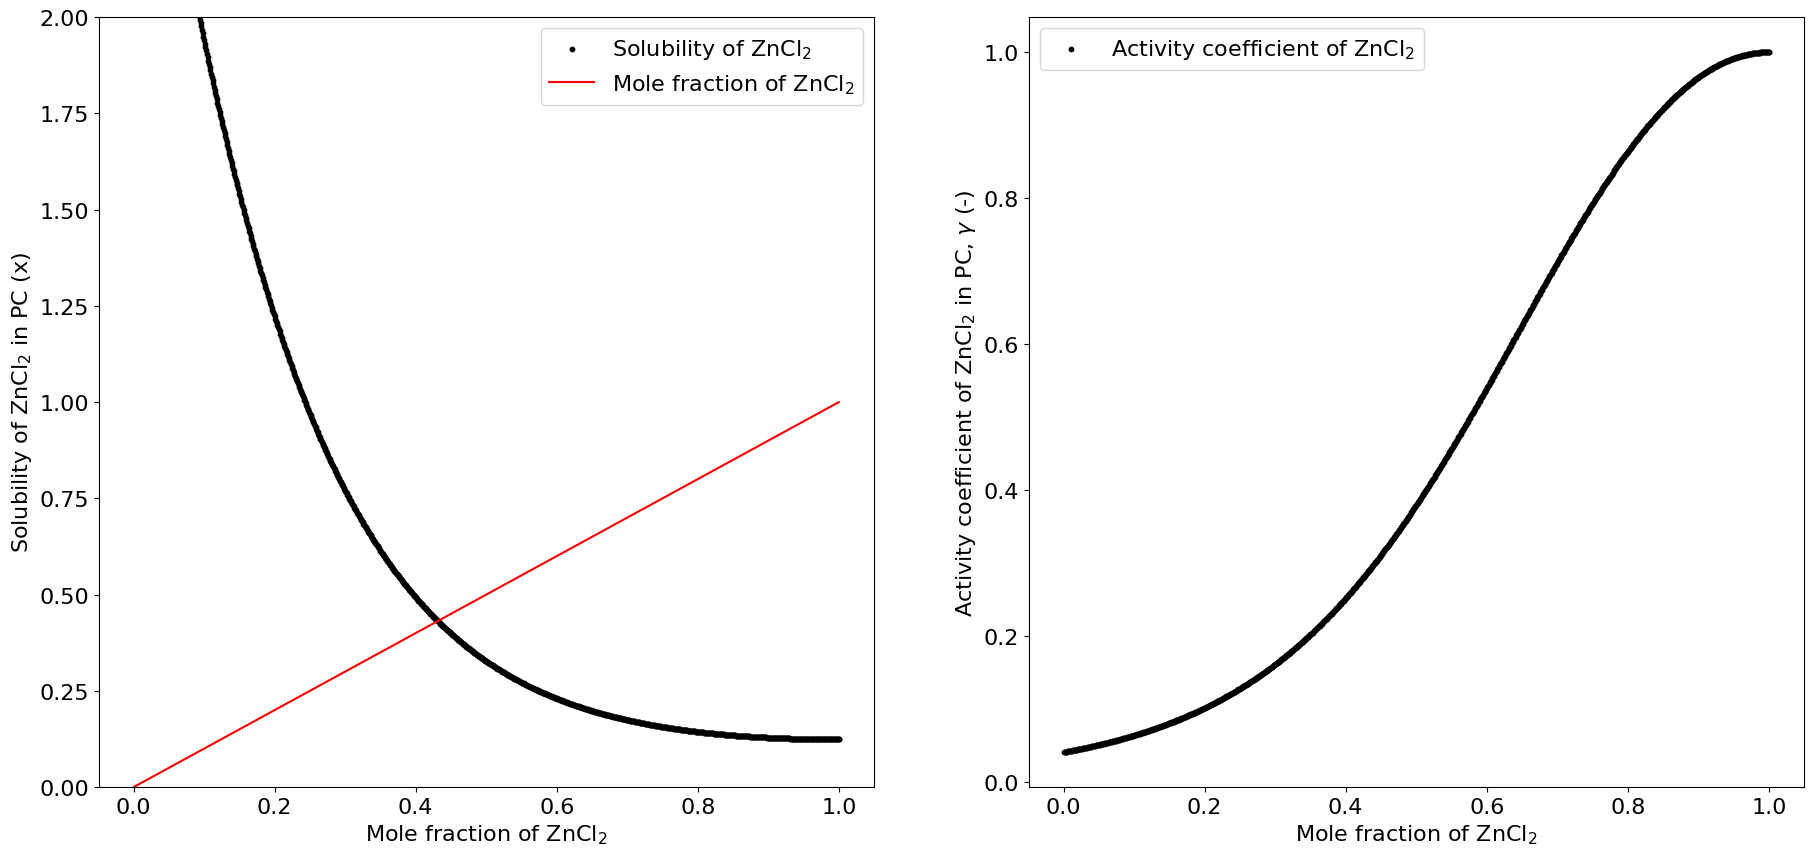

Solubility of ZnCl$_2$ (x): 0.43
Solubility of ZnCl$_2$ (x) assuming ideal solution (gamma = 1): 0.124


In [24]:
# Calculate solubility of ZnCl2 in PC

salt = r'ZnCl$_2$'

# Melting point and enthalpy of fusion of ZnCl2 salt
Tm_salt = 325+273.15    # K
dH_fus_salt = 10.30     # kJ/mol

# Mole fractions of ZnCl2 and PC
x_salt = np.linspace(0.001,1,1000)
x_PC = 1-x_salt

T = 298

profs = [get_sigma_profile(n)[0] for n in ['ZINC CHLORIDE','PROPYLENE CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_salt)):
    x = [x_salt[idx], x_PC[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['ZINC CHLORIDE','PROPYLENE CARBONATE']])    
    V_COSMO_A3 = np.array(V_COSMO_A3)
    lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    
    for i in range(2):
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_salt*1000/(gas_R*Tm_salt)*(1-Tm_salt/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == 999:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label=f'Solubility of {salt}')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label=f'Activity coefficient of {salt}')

ax1.plot(x_salt, x_salt, color='red', label=f'Mole fraction of {salt}')
ax1.set_xlabel(f'Mole fraction of {salt}')
ax1.set_ylabel(f'Solubility of {salt} in PC (x)')
ax1.set_ylim(bottom=0, top=2)
ax1.legend()

ax2.set_xlabel(f'Mole fraction of {salt}')
ax2.set_ylabel(rf'Activity coefficient of {salt} in PC, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

# Find value and index where mole fraction of ZnCl2 is equal to solubility of ZnCl2 (i.e., all ZnCl2 is dissolved)
for x in range(len(x_salt)):
    val = abs(x_sol[x] - x_salt[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(rf'Solubility of {salt} (x): {x_salt[min_idx]:.2f}')

ln_x_ideal = dH_fus_salt*1000/(gas_R*Tm_salt)*(1-Tm_salt/T)
print(rf'Solubility of {salt} (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')

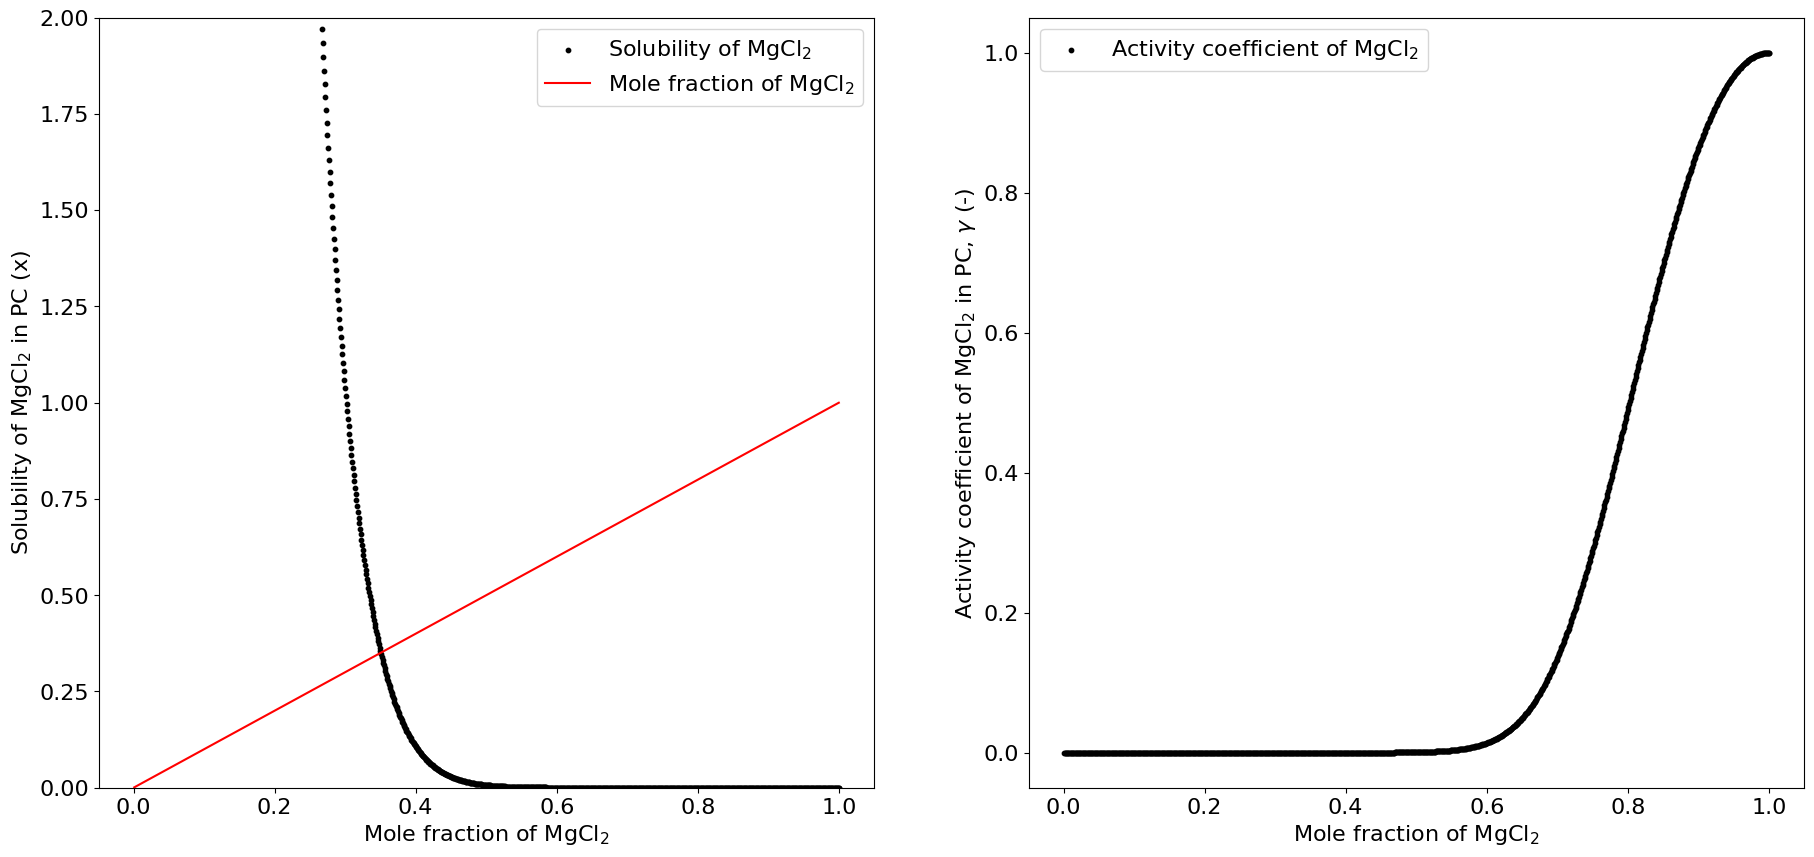

Solubility of MgCl$_2$ (x): 0.35
Solubility of MgCl$_2$ (x) assuming ideal solution (gamma = 1): 0.000


In [25]:
# Calculate solubility of MgCl2 in PC

salt = r'MgCl$_2$'

# Melting point and enthalpy of fusion of MgCl2 salt
Tm_salt = 714+273.15    # K
dH_fus_salt = 43.1      # kJ/mol

# Mole fractions of MgCl2 and PC
x_salt = np.linspace(0.001,1,1000)
x_PC = 1-x_salt

T = 298

profs = [get_sigma_profile(n)[0] for n in ['MAGNESIUM CHLORIDE','PROPYLENE CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_salt)):
    x = [x_salt[idx], x_PC[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['MAGNESIUM CHLORIDE','PROPYLENE CARBONATE']])    
    V_COSMO_A3 = np.array(V_COSMO_A3)
    lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    
    for i in range(2):
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_salt*1000/(gas_R*Tm_salt)*(1-Tm_salt/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == 999:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label=f'Solubility of {salt}')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label=f'Activity coefficient of {salt}')

ax1.plot(x_salt, x_salt, color='red', label=f'Mole fraction of {salt}')
ax1.set_xlabel(f'Mole fraction of {salt}')
ax1.set_ylabel(f'Solubility of {salt} in PC (x)')
ax1.set_ylim(bottom=0, top=2)
ax1.legend()

ax2.set_xlabel(f'Mole fraction of {salt}')
ax2.set_ylabel(rf'Activity coefficient of {salt} in PC, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

# Find value and index where mole fraction of MgCl2 is equal to solubility of MgCl2 (i.e., all MgCl2 is dissolved)
for x in range(len(x_salt)):
    val = abs(x_sol[x] - x_salt[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(rf'Solubility of {salt} (x): {x_salt[min_idx]:.2f}')

ln_x_ideal = dH_fus_salt*1000/(gas_R*Tm_salt)*(1-Tm_salt/T)
print(rf'Solubility of {salt} (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')

In [27]:
# 1 molal mixture of AlCl3 and PC 

mass_PC = 5.9751      # g, weighed out
mass_AlCl3 = 0.8001   # g, weighed out

mol_PC = mass_PC/Mw_PC
mol_AlCl3 = mass_AlCl3/Mw_AlCl3

x0_AlCl3 = mol_AlCl3/(mol_AlCl3 + mol_PC)
x0_PC = mol_PC/(mol_AlCl3 + mol_PC)
print(mol_AlCl3)
print(x0_AlCl3)
print(x0_PC)

# Melting point and enthalpy of fusion of MgCl2 salt
Tm_salt = 714+273.15    # K
dH_fus_salt = 43.1      # kJ/mol

0.006000404976713839
0.09298808938065897
0.9070119106193409


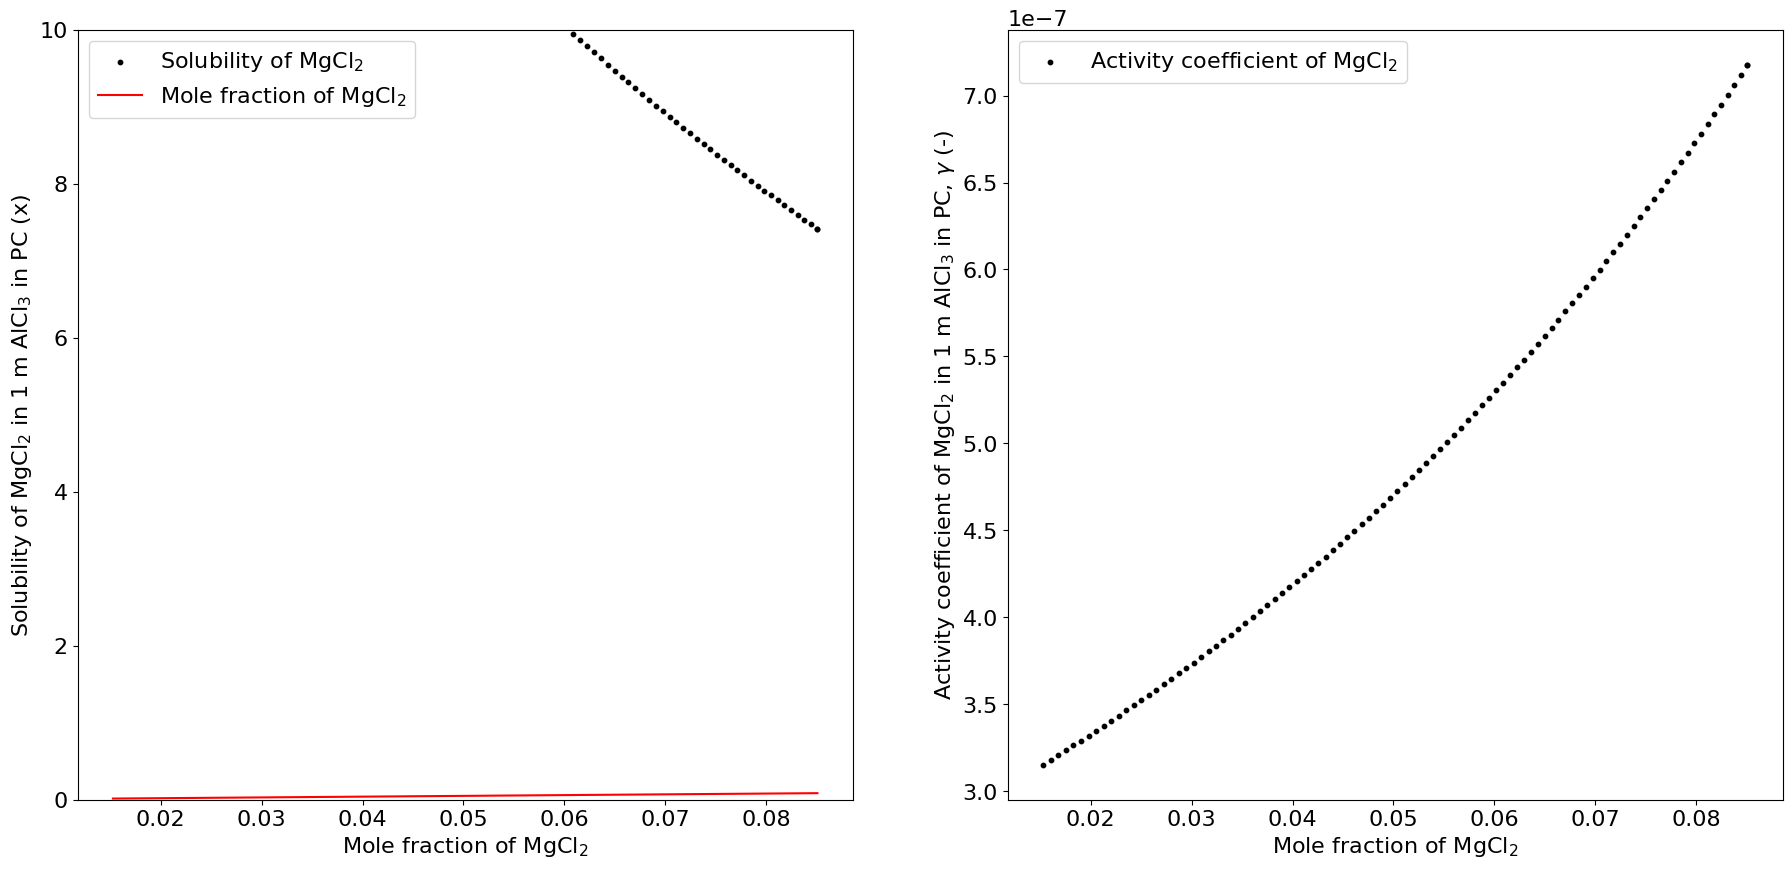

Solubility of MgCl$_2$ (x): 0.085
Solubility of MgCl$_2$ (x) assuming ideal solution (gamma = 1): 0.000


In [29]:
# Calculate solubilities of MgCl2 salt in 1 molal AlCl3 + PC mixture
# up to 1 molal of MgCl2 in PC

salt = r'MgCl$_2$'

mol_final_salt = mol_AlCl3

# Mole fractions of salt, AlCl3 and PC
mol_salt = np.linspace(0.001,mol_final_salt,100)

x_salt = mol_salt/(mol_AlCl3 + mol_PC + mol_salt)
x_AlCl3 = mol_AlCl3/(mol_AlCl3 + mol_PC + mol_salt)
x_PC = mol_PC/(mol_AlCl3 + mol_PC + mol_salt)

T = 298

profs = [get_sigma_profile(n)[0] for n in ['MAGNESIUM CHLORIDE','ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_salt)):
    x = [x_salt[idx],x_AlCl3[idx], x_PC[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(3)])/sum([x[i]*As[i] for i in range(3)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['MAGNESIUM CHLORIDE','ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']])
    V_COSMO_A3 = np.array(V_COSMO_A3)
    lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    
    for i in range(3):
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_salt*1000/(gas_R*Tm_salt)*(1-Tm_salt/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == 99:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label=f'Solubility of {salt}')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label=f'Activity coefficient of {salt}')

ax1.plot(x_salt, x_salt, color='red', label=f'Mole fraction of {salt}')
ax1.set_xlabel(f'Mole fraction of {salt}')
ax1.set_ylabel(f'Solubility of {salt} in 1 m AlCl$_3$ in PC (x)')
ax1.set_ylim(bottom=0, top=10)
ax1.legend()

ax2.set_xlabel(f'Mole fraction of {salt}')
ax2.set_ylabel(rf'Activity coefficient of {salt} in 1 m AlCl$_3$ in PC, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

# Find value and index where mole fraction of salt is equal to solubility of salt (i.e., all salt is dissolved)
for x in range(len(x_salt)):
    val = abs(x_sol[x] - x_salt[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(f'Solubility of {salt} (x): {x_salt[min_idx]:.3f}')

ln_x_ideal = dH_fus_salt*1000/(gas_R*Tm_salt)*(1-Tm_salt/T)
print(f'Solubility of {salt} (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')

In [12]:
# Melting point and enthalpy of fusion of AlCl3 and acetonitrile (AN)

Tm_AlCl3 = 192.6+273.15  # K
dH_fus_AlCl3 = 35.35     # kJ/mol
Tm_AN = -44+273.15       # K
dH_fus_AN = 8.16         # kJ/mol

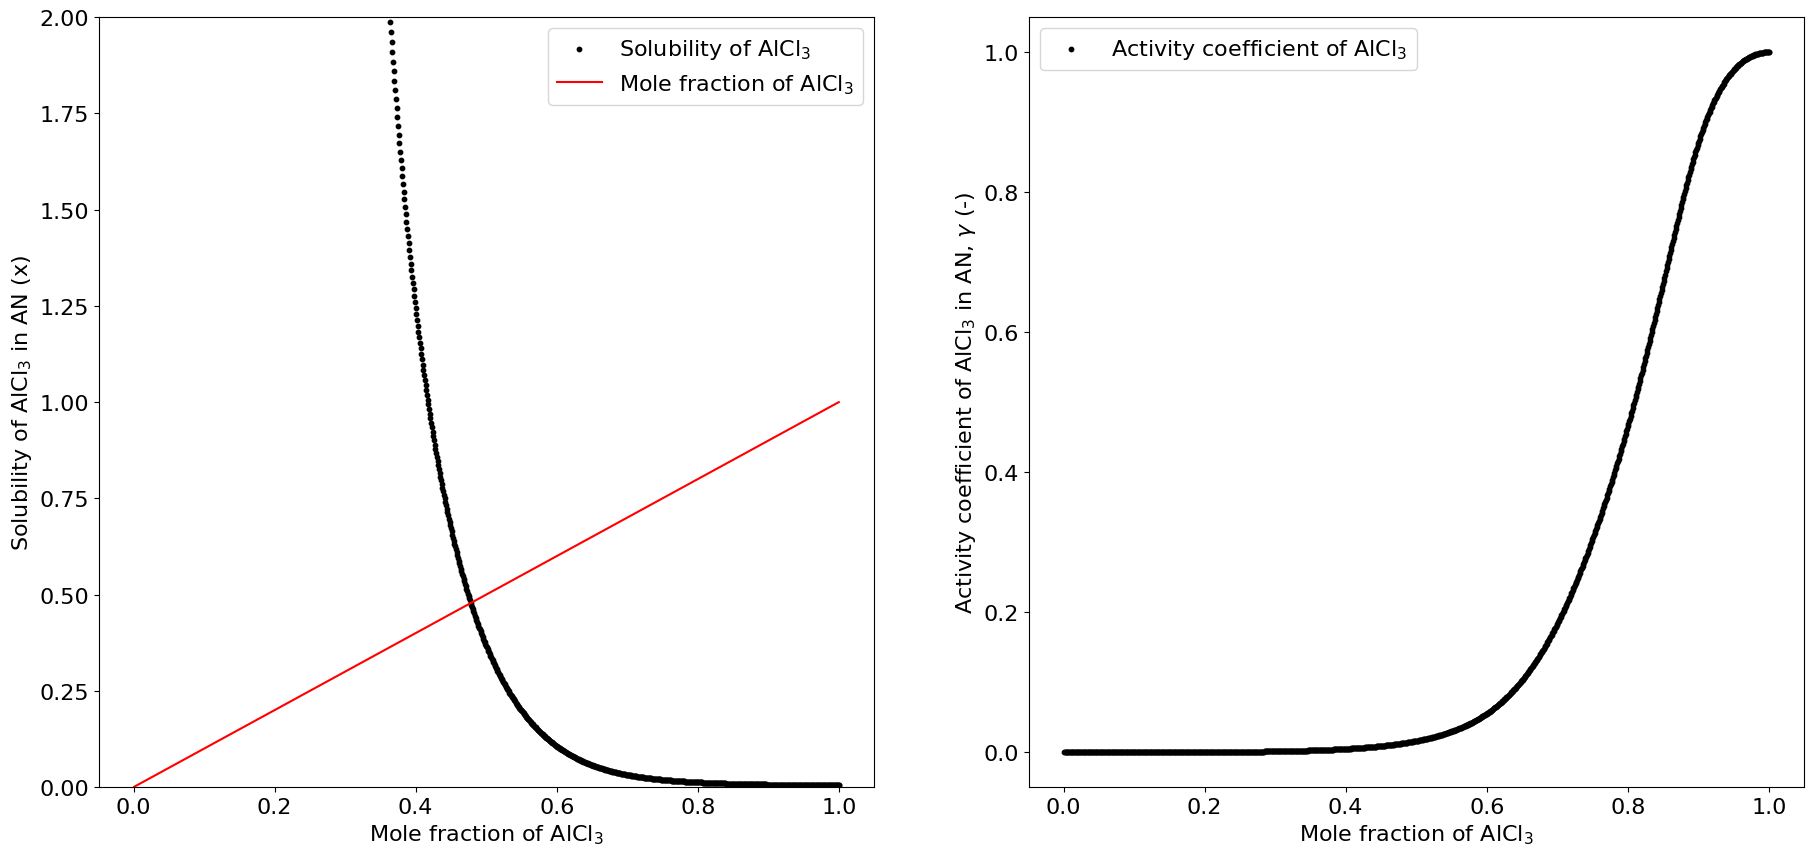

Solubility of AlCl3 (x): 0.48
Solubility of AlCl3 (x) assuming ideal solution (gamma = 1): 0.006


In [13]:
# Calculate solubilities of AlCl3 in AN

# Mole fractions of AlCl3 and AN
x_AlCl3 = np.linspace(0.001,1,1000)
x_AN = 1-x_AlCl3

T = 298

profs = [get_sigma_profile(n)[0] for n in ['ALUMINIUM CHLORIDE','ACETONITRILE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_AlCl3)):
    x = [x_AlCl3[idx], x_AN[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['ALUMINIUM CHLORIDE','ACETONITRILE']])    
    V_COSMO_A3 = np.array(V_COSMO_A3)
    lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    
    for i in range(2):
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_AlCl3*1000/(gas_R*Tm_AlCl3)*(1-Tm_AlCl3/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == 999:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label='Solubility of AlCl$_3$')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label='Activity coefficient of AlCl$_3$')

ax1.plot(x_AlCl3, x_AlCl3, color='red', label='Mole fraction of AlCl$_3$')
ax1.set_xlabel('Mole fraction of AlCl$_3$')
ax1.set_ylabel('Solubility of AlCl$_3$ in AN (x)')
ax1.set_ylim(bottom=0, top=2)
ax1.legend()

ax2.set_xlabel('Mole fraction of AlCl$_3$')
ax2.set_ylabel(r'Activity coefficient of AlCl$_3$ in AN, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

# Find value and index where mole fraction of AlCl3 is equal to solubility of AlCl3 (i.e., all AlCl3 is dissolved)
for x in range(len(x_AlCl3)):
    val = abs(x_sol[x] - x_AlCl3[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(f'Solubility of AlCl3 (x): {x_AlCl3[min_idx]:.2f}')

ln_x_ideal = dH_fus_AlCl3*1000/(gas_R*Tm_AlCl3)*(1-Tm_AlCl3/T)
print(f'Solubility of AlCl3 (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')

<Figure size 640x480 with 0 Axes>

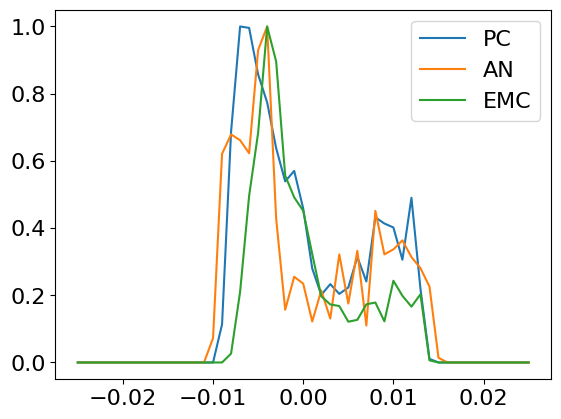

<Figure size 640x480 with 0 Axes>

In [16]:
prof = get_sigma_profile('PROPYLENE CARBONATE')[0]
As = prof['p(sigma)*A [A^2]'].sum()
plt.plot(prof['sigma [e/A^2]'], prof['p(sigma)*A [A^2]']/prof['p(sigma)*A [A^2]'].max(), label='PC')

prof = get_sigma_profile('ACETONITRILE')[0]
As = prof['p(sigma)*A [A^2]'].sum()
plt.plot(prof['sigma [e/A^2]'], prof['p(sigma)*A [A^2]']/prof['p(sigma)*A [A^2]'].max(), label='AN')

prof = get_sigma_profile('ETHYL METHYL CARBONATE')[0]
As = prof['p(sigma)*A [A^2]'].sum()
plt.plot(prof['sigma [e/A^2]'], prof['p(sigma)*A [A^2]']/prof['p(sigma)*A [A^2]'].max(), label='EMC')

plt.legend()
plt.figure()


0.00022902199712166588


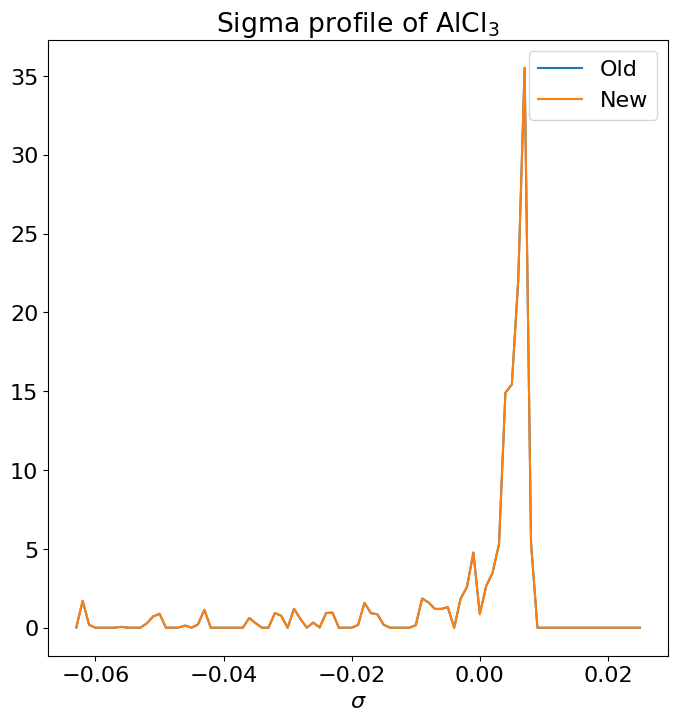

0.014986879551078774


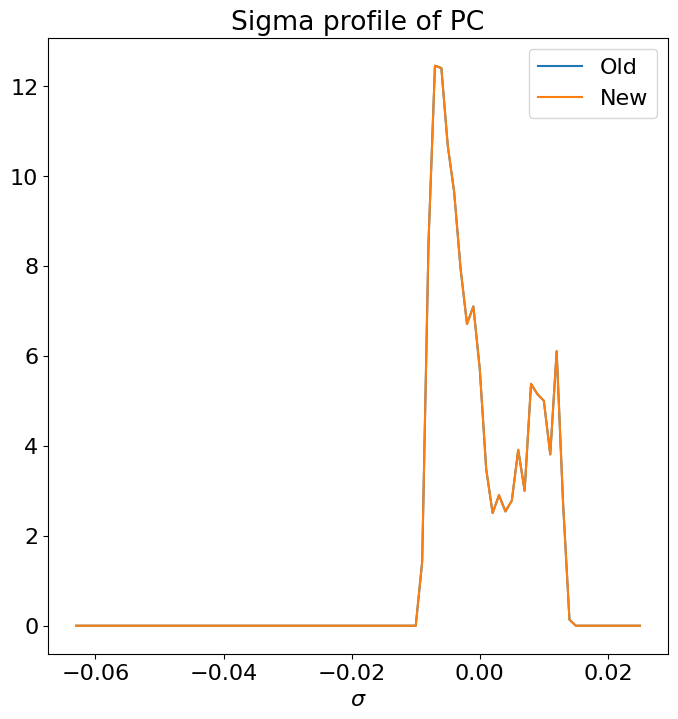

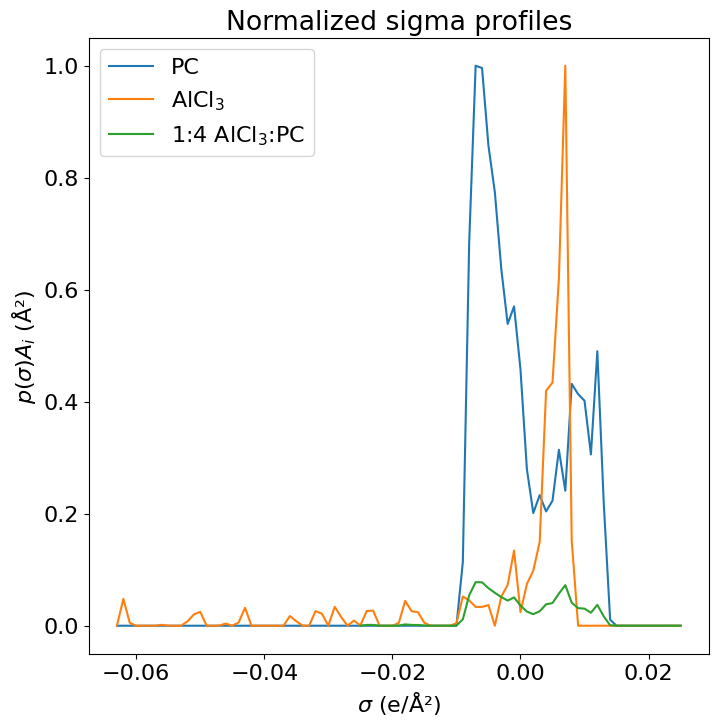

In [18]:
# Sigma profiles of old and new AlCl3 (new = combined method, more accurate)

path = '/home/ystein-gullbrekken/Github/cosmo_files/sigma1'

AlCl3_old = pandas.read_csv(os.path.join(path, 'AlCl3.sigma'), sep=' ', skiprows=3, names=['sigma [e/A^2]', 'p(sigma)*A [A^2]'])
AlCl3_new = pandas.read_csv(os.path.join(path, 'AlCl3_newmethod.sigma'), sep=' ', skiprows=3, names=['sigma [e/A^2]', 'p(sigma)*A [A^2]'])

print(sum(abs(AlCl3_old['p(sigma)*A [A^2]']-AlCl3_new['p(sigma)*A [A^2]'])))

fig, ax = plt.subplots(figsize=(8, 8))  # Create a figure and an axes.
ax.plot(AlCl3_old['sigma [e/A^2]'], AlCl3_old['p(sigma)*A [A^2]'], label='Old')
ax.plot(AlCl3_new['sigma [e/A^2]'], AlCl3_new['p(sigma)*A [A^2]'], label='New')
ax.set_xlabel(r'$\sigma$')
ax.set_title(r'Sigma profile of AlCl$_3$')
ax.legend()
plt.show()

PC_old = pandas.read_csv(os.path.join(path, 'PC.sigma'), sep=' ', skiprows=3, names=['sigma [e/A^2]', 'p(sigma)*A [A^2]'])
PC_new = pandas.read_csv(os.path.join(path, 'PC_newmethod.sigma'), sep=' ', skiprows=3, names=['sigma [e/A^2]', 'p(sigma)*A [A^2]'])

print(sum(abs(PC_old['p(sigma)*A [A^2]']-PC_new['p(sigma)*A [A^2]'])))

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(PC_old['sigma [e/A^2]'], PC_old['p(sigma)*A [A^2]'], label='Old')
ax.plot(PC_new['sigma [e/A^2]'], PC_new['p(sigma)*A [A^2]'], label='New')
ax.set_xlabel(r'$\sigma$')
ax.set_title('Sigma profile of PC')
ax.legend()
plt.show()

profs = [get_sigma_profile(n)[0] for n in ['ALUMINIUM CHLORIDE','PROPYLENE CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]
x = [0.2,1-0.2]
psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(PC_old['sigma [e/A^2]'], PC_old['p(sigma)*A [A^2]']/PC_old['p(sigma)*A [A^2]'].max(), label='PC')
ax.plot(AlCl3_old['sigma [e/A^2]'], AlCl3_old['p(sigma)*A [A^2]']/AlCl3_old['p(sigma)*A [A^2]'].max(), label=r'AlCl$_3$')
ax.plot(profs[0]['sigma [e/A^2]'], psigma_mix, label=r'1:4 AlCl$_3$:PC')
ax.set_xlabel(r'$\sigma$ (e/Å²)')
ax.set_ylabel(r'$p(\sigma)A_i$ (Å²)')
ax.set_title('Normalized sigma profiles')
ax.legend()
plt.show()

In [10]:
# Melting point and enthalpy of fusion of AlCl3 and ethyl methyl carbonate (EMC)

Tm_AlCl3 = 192.6+273.15  # K
dH_fus_AlCl3 = 35.35     # kJ/mol
Tm_EMC = -14+273.15      # K
#dH_fus_EMC = 8.16        # kJ/mol

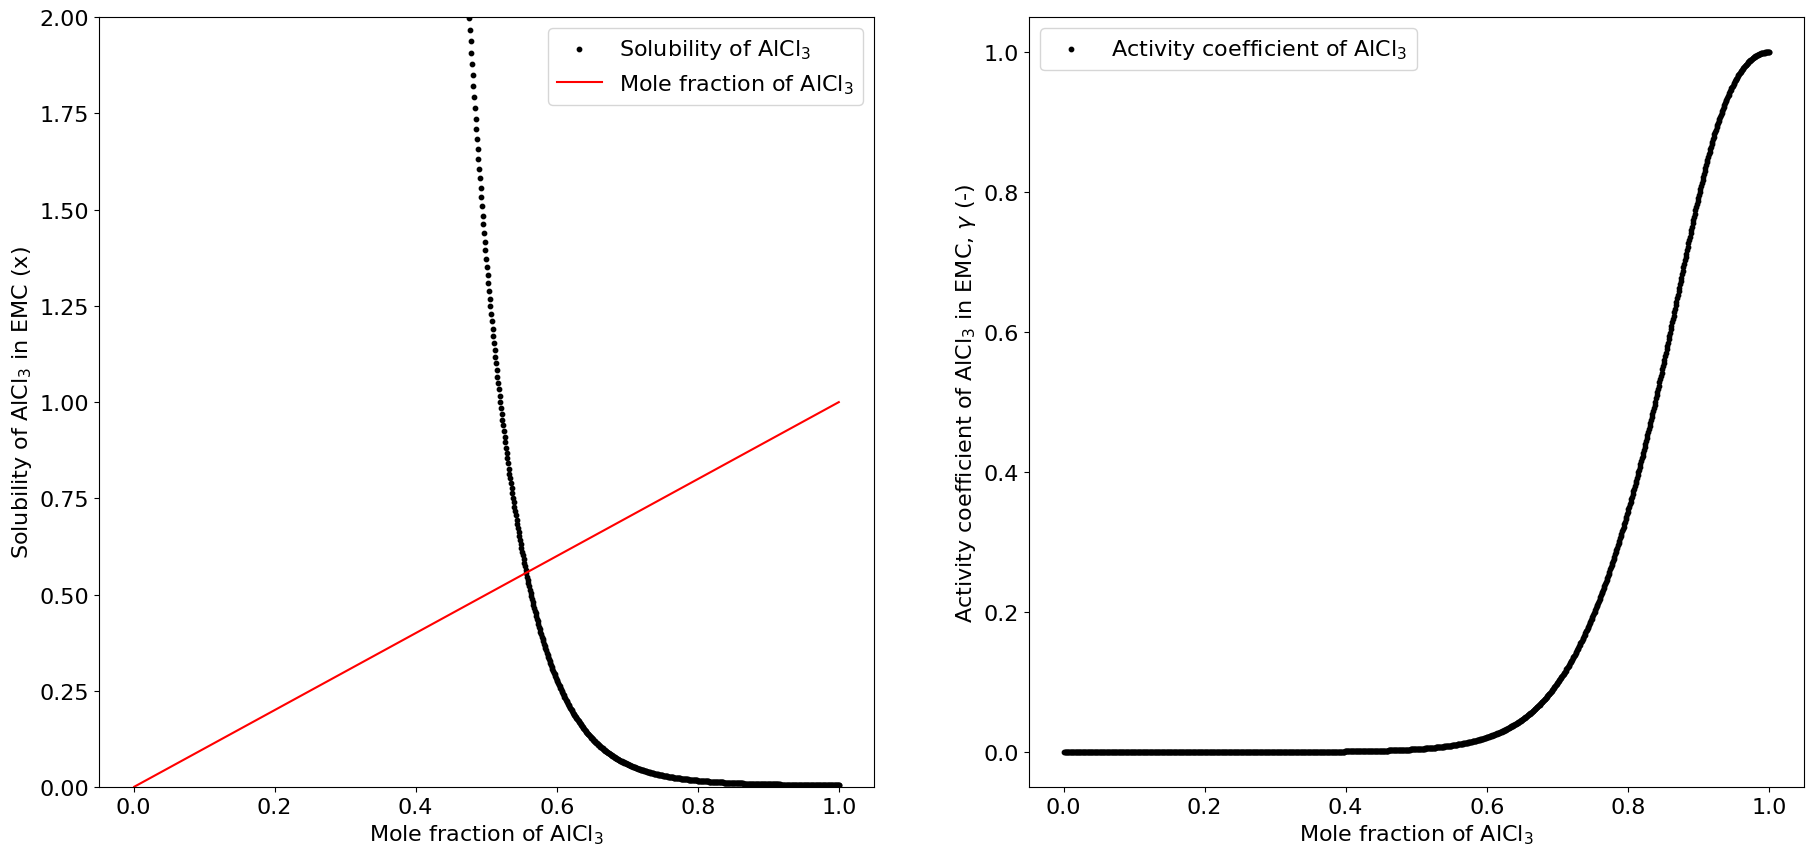

Solubility of AlCl3 (x): 0.56
Solubility of AlCl3 (x) assuming ideal solution (gamma = 1): 0.006


In [11]:
# Calculate solubilities of AlCl3 in EMC

# Mole fractions of AlCl3 and EMC
x_AlCl3 = np.linspace(0.001,1,1000)
x_solvent = 1-x_AlCl3

T = 298

profs = [get_sigma_profile(n)[0] for n in ['ALUMINIUM CHLORIDE','ETHYL METHYL CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_AlCl3)):
    x = [x_AlCl3[idx], x_solvent[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['ALUMINIUM CHLORIDE','ETHYL METHYL CARBONATE']])    
    V_COSMO_A3 = np.array(V_COSMO_A3)
    lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    
    for i in range(2):
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_AlCl3*1000/(gas_R*Tm_AlCl3)*(1-Tm_AlCl3/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == 999:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label='Solubility of AlCl$_3$')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label='Activity coefficient of AlCl$_3$')

ax1.plot(x_AlCl3, x_AlCl3, color='red', label='Mole fraction of AlCl$_3$')
ax1.set_xlabel('Mole fraction of AlCl$_3$')
ax1.set_ylabel('Solubility of AlCl$_3$ in EMC (x)')
ax1.set_ylim(bottom=0, top=2)
ax1.legend()

ax2.set_xlabel('Mole fraction of AlCl$_3$')
ax2.set_ylabel(r'Activity coefficient of AlCl$_3$ in EMC, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

# Find value and index where mole fraction of AlCl3 is equal to solubility of AlCl3 (i.e., all AlCl3 is dissolved)
for x in range(len(x_AlCl3)):
    val = abs(x_sol[x] - x_AlCl3[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(f'Solubility of AlCl3 (x): {x_AlCl3[min_idx]:.2f}')

ln_x_ideal = dH_fus_AlCl3*1000/(gas_R*Tm_AlCl3)*(1-Tm_AlCl3/T)
print(f'Solubility of AlCl3 (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')

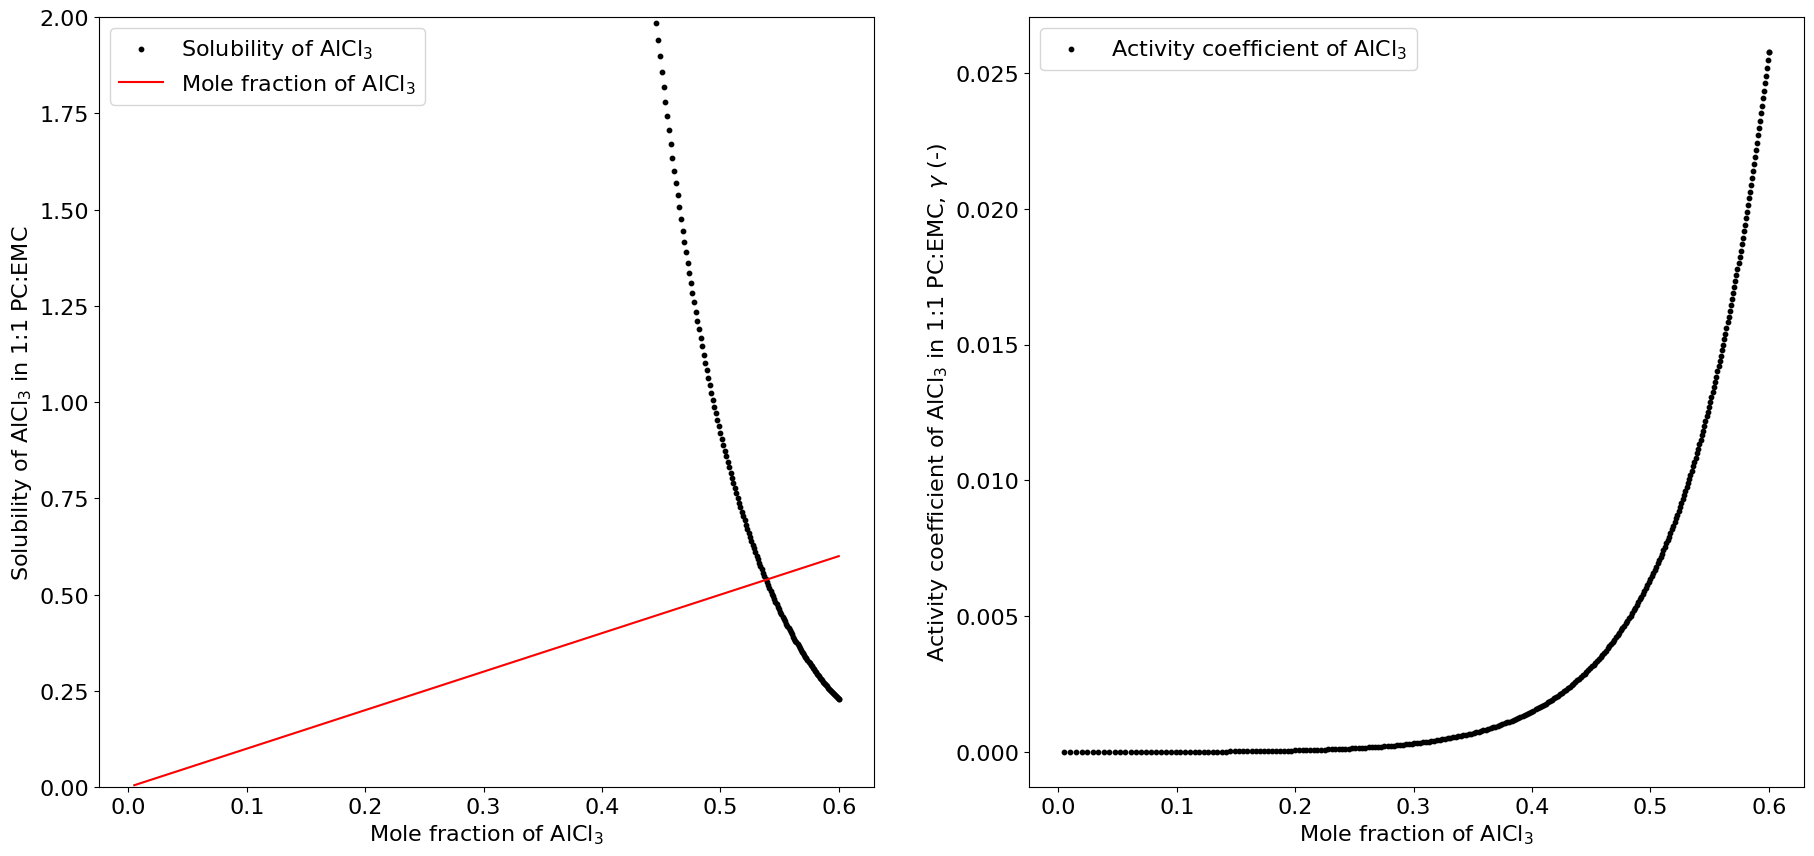

Solubility of AlCl3 (x): 0.538
Solubility of AlCl3 (x) assuming ideal solution (gamma = 1): 0.006


In [14]:
# Calculate solubilities of AlCl3 in 1:1 molar mix of PC:EMC

mol_PC = 1
mol_EMC = 1

# Mole fractions of AlCl3, PC and EMC
mol_AlCl3 = np.linspace(0.01,3,300)

x_AlCl3 = mol_AlCl3/(mol_AlCl3 + mol_EMC + mol_PC)
x_PC = mol_PC/(mol_AlCl3 + mol_EMC + mol_PC)
x_EMC = mol_EMC/(mol_AlCl3 + mol_EMC + mol_PC)

T = 298

profs = [get_sigma_profile(n)[0] for n in ['ALUMINIUM CHLORIDE','PROPYLENE CARBONATE','ETHYL METHYL CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_AlCl3)):
    x = [x_AlCl3[idx],x_PC[idx],x_EMC[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(3)])/sum([x[i]*As[i] for i in range(3)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['ALUMINIUM CHLORIDE','PROPYLENE CARBONATE','ETHYL METHYL CARBONATE']])
    V_COSMO_A3 = np.array(V_COSMO_A3)
    lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    
    for i in range(3):
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_AlCl3*1000/(gas_R*Tm_AlCl3)*(1-Tm_AlCl3/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == len(x_AlCl3)-1:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label='Solubility of AlCl$_3$')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label='Activity coefficient of AlCl$_3$')

ax1.plot(x_AlCl3, x_AlCl3, color='red', label='Mole fraction of AlCl$_3$')
ax1.set_xlabel('Mole fraction of AlCl$_3$')
ax1.set_ylabel('Solubility of AlCl$_3$ in 1:1 PC:EMC')
ax1.set_ylim(bottom=0, top=2)
ax1.legend()

ax2.set_xlabel('Mole fraction of AlCl$_3$')
ax2.set_ylabel(r'Activity coefficient of AlCl$_3$ in 1:1 PC:EMC, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

# Find value and index where mole fraction of AlCl3 is equal to solubility of AlCl3 (i.e., all AlCl3 is dissolved)
for x in range(len(x_AlCl3)):
    val = abs(x_sol[x] - x_AlCl3[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(f'Solubility of AlCl3 (x): {x_AlCl3[min_idx]:.2f}')

ln_x_ideal = dH_fus_AlCl3*1000/(gas_R*Tm_AlCl3)*(1-Tm_AlCl3/T)
print(f'Solubility of AlCl3 (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')

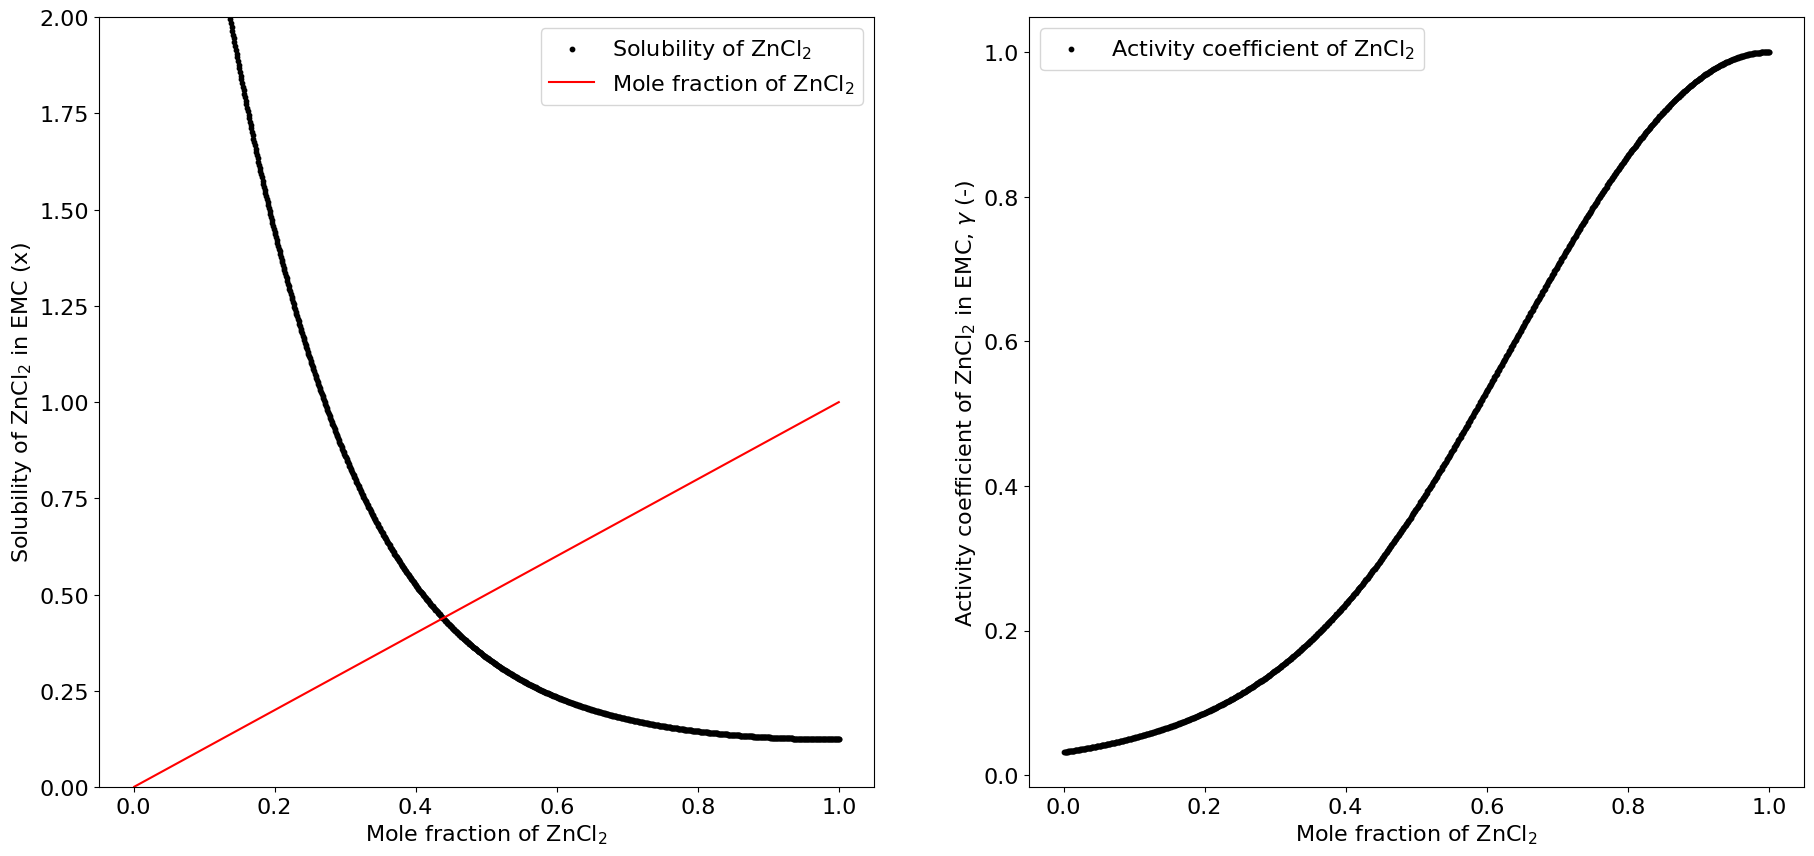

Solubility of ZnCl$_2$ (x): 0.44
Solubility of ZnCl$_2$ (x) assuming ideal solution (gamma = 1): 0.124


In [17]:
# Calculate solubility of ZnCl2 in EMC

salt = r'ZnCl$_2$'

# Melting point and enthalpy of fusion of ZnCl2 salt
Tm_salt = 325+273.15    # K
dH_fus_salt = 10.30     # kJ/mol

# Mole fractions of ZnCl2 and EMC
x_salt = np.linspace(0.001,1,1000)
x_EMC = 1-x_salt

T = 298

profs = [get_sigma_profile(n)[0] for n in ['ZINC CHLORIDE','ETHYL METHYL CARBONATE']]
As = [prof['p(sigma)*A [A^2]'].sum() for prof in profs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,10))

x_sol = []

for idx in range(len(x_salt)):
    x = [x_salt[idx], x_EMC[idx]]
    psigma_mix = sum([x[i]*profs[i]['p(sigma)*A [A^2]'] for i in range(2)])/sum([x[i]*As[i] for i in range(2)])
    profs,V_COSMO_A3 = zip(*[get_sigma_profile(name) for name in ['ZINC CHLORIDE','ETHYL METHYL CARBONATE']])    
    V_COSMO_A3 = np.array(V_COSMO_A3)
    lnGamma_mix = np.log(get_Gamma(T, np.array(psigma_mix)))
    
    for i in range(2):
        if i == 0:
            ln_x = -get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix) + dH_fus_salt*1000/(gas_R*Tm_salt)*(1-Tm_salt/T)
            x_sol.append(np.exp(ln_x))
            
            ax1.scatter(x[i], np.exp(ln_x), s=10, color='black')
            ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black')

            if idx == 999:
                ax1.scatter(x[i], np.exp(ln_x), s=10, color='black', label=f'Solubility of {salt}')
                ax2.scatter(x[i], np.exp(get_lngamma(T, x, i, np.array(psigma_mix), profs, V_COSMO_A3, lnGamma_mix = lnGamma_mix)), s=10, color='black', label=f'Activity coefficient of {salt}')

ax1.plot(x_salt, x_salt, color='red', label=f'Mole fraction of {salt}')
ax1.set_xlabel(f'Mole fraction of {salt}')
ax1.set_ylabel(f'Solubility of {salt} in EMC (x)')
ax1.set_ylim(bottom=0, top=2)
ax1.legend()

ax2.set_xlabel(f'Mole fraction of {salt}')
ax2.set_ylabel(rf'Activity coefficient of {salt} in EMC, $\gamma$ (-)')
ax2.legend()

plt.show()

min_val = 1000
min_idx = None

# Find value and index where mole fraction of ZnCl2 is equal to solubility of ZnCl2 (i.e., all ZnCl2 is dissolved)
for x in range(len(x_salt)):
    val = abs(x_sol[x] - x_salt[x])
    if val < min_val:
        min_val = val
        min_idx = x

print(rf'Solubility of {salt} (x): {x_salt[min_idx]:.2f}')

ln_x_ideal = dH_fus_salt*1000/(gas_R*Tm_salt)*(1-Tm_salt/T)
print(rf'Solubility of {salt} (x) assuming ideal solution (gamma = 1): {np.exp(ln_x_ideal):.3f}')